## Notebook for Linearising, Normalising and Fitting Raw Data

## We recommend running the notebook without uncommenting the user interface parts first. Troubleshooting tips can be found at end of notebook

## Packages needed for Notebook. In addition, for fitting the packages 'lmfit' and 'elecsus' are needed which can be found here: https://github.com/durham-qlm/ElecSus

In [32]:
from mpl_toolkits.mplot3d import axes3d # 3D figure
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import math
import scipy.interpolate as interpolate
import scipy.signal as signal
from scipy.optimize import curve_fit

from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as tck
import scipy.io as sio
import pandas as pd
import matplotlib.ticker as ticker


import os

from pylab import *
from numpy import *
from matplotlib.widgets import Button
from matplotlib import rc

import glob
import csv
params={'axes.labelsize':20,'xtick.labelsize':15,'ytick.labelsize':15}
rcParams.update(params)

In [33]:
# Colour Palette
rcParams["axes.prop_cycle"]=cycler(color=['#68246D', '#FFD53A', '#00AEEF', '#BE1E2D', '#AFA961'])

## At several stages of the data processing, we require polynomials of various degrees, they are all defined here

In [34]:
## Define functions

def poly1(x,a,b):
    x = np.array(x)
    return a*x + b

def poly2(x,a,b,c):
    x = np.array(x)
    return a*x**2 + b*x + c

def poly3(x,a,b,c,d):
    x = np.array(x)
    return a*x**3 + b*x**2 + c*x + d

def poly4(x,a,b,c,d,e):
    x = np.array(x)
    return a*x**4 + b*x**3 + c**2 + d*x + e

def poly5(x,a,b,c,d,e,f):
    x = np.array(x)
    return a*x**5 + b*x**4+ c*x**3 + d*x**2 + e*x + f

def poly6(x,a,b,c,d,e,f,g):
    x = np.array(x)
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

def poly7(x,a,b,c,d,e,f,g,h):
    x = np.array(x)
    return a*x**7 + b*x**6 + c*x**5 + d*x**4 + e*x**3 + f*x**2 + g*x + h

def poly8(x,a,b,c,d,e,f,g,h,i):
    x = np.array(x)
    return a*x**8 + b*x**7 + c*x**6 + d*x**5 + e*x**4 + f*x**3 + g*x**2 + h*x + i

def poly9(x,a,b,c,d,e,f,g,h,i,j):
    x = np.array(x)
    return a*x**9 + b*x**8 + c*x**7 + d*x**6 + e*x**5 + f*x**4 + g*x**3 + h*x**2 + i*x + j

def poly10(x,a,b,c,d,e,f,g,h,i,j,k):
    x = np.array(x)
    return a*x**10 + b*x**9 + c*x**8 + d*x**7+ e*x**6 + f*x**5 + g*x**4 + h*x**3 + i*x**2 + j*x+k

def poly11(x,a,b,c,d,e,f,g,h,i,j,k,l):
    x = np.array(x)
    return a*x**11 + b*x**10 + c*x**9 + d*x**8 + e*x**7 + f*x**6 + g*x**5 + h*x**4 + i*x**3 + j*x**2+k*x+l

def poly12(x,a,b,c,d,e,f,g,h,i,j,k,l,m):
    x = np.array(x)
    return a*x**12 + b*x**11 + c*x**10 + d*x**9 + e*x**8 + f*x**7 + g*x**6 + h*x**5 + i*x**4 + j*x**3+k*x**2+l*x+m



## Replace file path with file path where Notebook_Folder is located on your computer

In [35]:
os.chdir('/home/otps3141/Documents/Dokumente/ETH QE/Master Thesis Imperial/Thesis/Code/ElecSus fitting/scope2elecsus/Notebook_Folder')

## We import all the data to be processed in this notebook.

## We will process from start to finish a spectrum at 20C (from paper)
## We will additionally fit spectra at 40 and 73C (from paper)
## In the Appendix, we normalise the same 73C to show how the zero offset can be extracted (and additionally how to normalise difficult spectra)

In [36]:
#Raw Room temperature Nat abundance Rb Spectra Data
Rb_spectrum= np.loadtxt('./Dopp_Broadened_20C.csv',delimiter = ',',dtype='float',skiprows=1)

#Pre-linearised Hot nat abundance Rb Spectrum used to find zero
Hot_Spectrum = np.loadtxt('./Dopp_Broadened_73C Lin.csv',delimiter = ',',dtype='float',skiprows=1)

#Pre-normalised nat abundance Rb Spectral data which is fit later
Rb_spectrum2 = np.loadtxt('./Dopp_Broadened_40C Norm.csv',delimiter = ',',dtype='float',skiprows=1)
Rb_spectrum3 = np.loadtxt('./Dopp_Broadened_73C Norm.csv',delimiter = ',',dtype='float',skiprows=1)

etalon_data = np.loadtxt('./Etalon.csv',delimiter = ',',dtype='float',skiprows=1)

Sub_Doppler = np.loadtxt('./Sub_Doppler Spectrum.csv',delimiter = ',',dtype='float',skiprows=1)

Time = Rb_spectrum[:,0] # units: ms  # data for time in first coloumn
Dopp_Broad_Spec = Rb_spectrum[:,1] #units: V #data for voltage in second column
Etalon = etalon_data[:,1] # units: ms  # data for time in first coloumn
Sub_Dopp=Sub_Doppler[:,1] #units: V #data for voltage in second column

Hot_Spectrum_Frequencies=Hot_Spectrum[:,0] #units: GHz (Note 1e3*MHz)
Hot_Spectrum_Voltages=Hot_Spectrum[:,1] #units: V

Dopp_Broad_Spec_2_Norm_Detunings= Rb_spectrum2[:,0] #units: MHz
Dopp_Broad_Spec_2_Norm_Vals= Rb_spectrum2[:,1] #units: Normalised Transmission

Dopp_Broad_Spec_3_Norm_Detunings= Rb_spectrum3[:,0] #units: MHz
Dopp_Broad_Spec_3_Norm_Vals= Rb_spectrum3[:,1] #units: Normalised Transmission



## Step 1: Cropping Data to Range of Interest

## Interactive plot to crop data to region of interest. Two points required. 

## Do note for normalisation later in the process, you will need to include some data away from the resonances (See Steps 3 and 5). 

In [37]:
'''
%matplotlib qt
plt.plot(Time,Etalon/max(Etalon))
plt.plot(Time,Dopp_Broad_Spec)
plt.plot(Time,Sub_Dopp)

 
  
print(r'Select region of interest')
x_crop = plt.ginput(2)  # after 2 click of mouse of the figure, figure will disappear and give us what we want. 


plt.show(block=False)  #figure windows are displayed and return immediately
plt.close()  # It plots the graph in seperate windows'''

"\n%matplotlib qt\nplt.plot(Time,Etalon/max(Etalon))\nplt.plot(Time,Dopp_Broad_Spec)\nplt.plot(Time,Sub_Dopp)\n\n \n  \nprint(r'Select region of interest')\nx_crop = plt.ginput(2)  # after 2 click of mouse of the figure, figure will disappear and give us what we want. \n\n\nplt.show(block=False)  #figure windows are displayed and return immediately\nplt.close()  # It plots the graph in seperate windows"

## Cropped Points Used in Paper 

In [38]:
x_crop=[(-0.064253938172043, 0.649457235915466),(0.07161903837365591, 0.5843899211873785)]

In [39]:
%matplotlib inline 

## In the diagram below, we normalise the data and add +1 to Sub Dopp so that we can see each signal clearly. We do not use this normalised and offset data going forward. This is purely to check data before continuing processing.

Text(0, 0.5, 'Photodiode Output (V)')

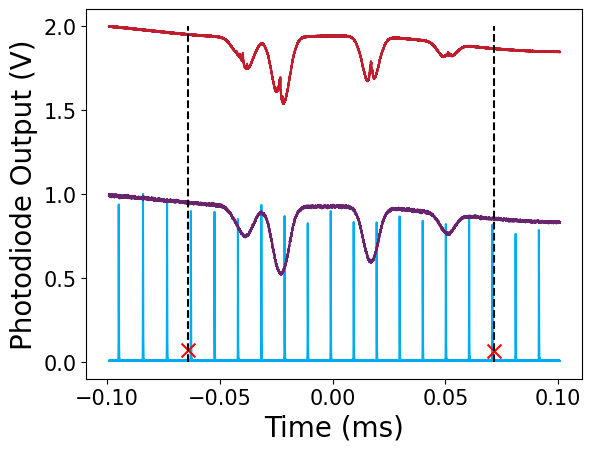

In [40]:
for i in x_crop:
    plt.scatter(i[0],i[1]/max(Etalon),s=100,marker='x',zorder=2,color='red')
    plt.vlines(i[0],0,2,linestyle='dashed',color='black')
plt.plot(Time,Etalon/max(Etalon),zorder=1,color='#00AEEF') 
plt.plot(Time,Dopp_Broad_Spec/max(Dopp_Broad_Spec),zorder=1,color='#68246D')
plt.plot(Time,Sub_Dopp/max(Sub_Dopp)+1,zorder=1,color='#BE1E2D')
plt.xlabel('Time (ms)')
plt.ylabel('Photodiode Output (V)')

In [41]:
# Create new x-axis

xstart = x_crop[0][0] 
xfinish = x_crop[1][0]


#Create new x-axis range
start = int((x_crop[0][0] - Time.min()) * len(Time)/(Time.max() - Time.min()))
finish = int((x_crop[1][0] - Time.min()) * len(Time)/(Time.max() - Time.min()))
print(start, finish)

ystart = x_crop[0][1]
yfinish = x_crop[1][1]



34946 170819


## We Set Time to start at 0 ms.

## This way when we calculate for absolute frequency we can easily readoff the y-intercept as the shift required to convert from frequency to detuning (See Step 5).

In [42]:
# Shorten raw data
Time = Time[start:finish]
Time=Time-Time[0] #Set first data to be at t=0ms
Etalon = Etalon[start:finish]
Dopp_Broad_Spec = Dopp_Broad_Spec[start:finish]
Sub_Dopp= Sub_Dopp[start:finish]


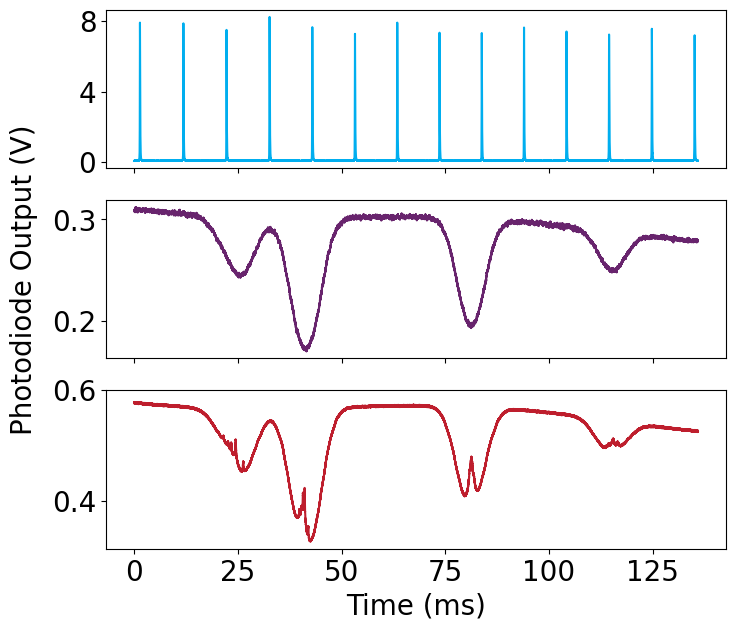

In [43]:
# b) from Figure 7
fig,axs=plt.subplots(3,sharex=True,figsize=(8,7))
axs[0].plot(Time*1e3, Etalon,color='#00AEEF')
axs[1].plot(Time*1e3, Dopp_Broad_Spec, color='#68246D')
axs[2].plot(Time*1e3, Sub_Dopp,color='#BE1E2D')
axs[2].set_xlabel('Time (ms)')
axs[1].set_ylabel('Photodiode Output (V)',fontsize=20, labelpad=10)
axs[2].set_yticks([0.4,0.6])
axs[0].set_yticks([0,4,8])
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=20)

## Step 2: Linearising the scan using an etalon. (This follows Section 3.1 in paper)

## Detecting etalon peaks. Important parameters are 'distance' and 'height' which you may need to change for different data

In [44]:
## Normalise etalon trace # normalise means the max value for etalon(voltage or signal) must be 1 in the graph

Normalised_Etalon = Etalon/max(Etalon)

## Find peaks of etalon trace

#print('Detect etalon peaks with minimum height and distance defined')
#height and distance arguments important if etalon detector detects more or less peaks than expected
indexes, _ = signal.find_peaks(Normalised_Etalon, height=0.7, distance=100) # scipy.signal.find_peak means find peak inside the signal that follow or agree with what I wrote inside()
#print('Peaks are: %s' % (indexes)) # %s use to add a string , %s'%() means string must be follow indexes above
findpeak=indexes,_
peakpos = findpeak[0] # list of peaks positions that has same indexes,_ properties  

Etalon_peak=[]
Time_peak=[]
for n in peakpos:  # n; integral number
    y = Normalised_Etalon[n]
    Etalon_peak.append(y) # append means the values of y must be added to etalon peak [, , , ,..]
    x = Time[n]
    Time_peak.append(x) 
    

## Check etalon peaks have been dectected correctly

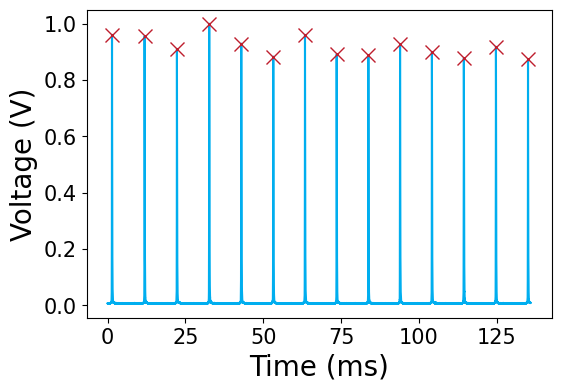

In [45]:
## Plot Normalised etalon with peak locators
%matplotlib inline
plt.figure(figsize=(6, 4))
plt.plot(Time*1e3, Normalised_Etalon,zorder=1,color='#00AEEF')  
plt.plot(np.array(Time_peak)*1e3,Etalon_peak,'x',markersize=10,zorder=2,color='#BE1E2D')
#plt.legend(loc='best') # add label (title or axes names to figure based on information below and put it in best location)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')


plt.show()

## Give the etalon peaks a number in order of appearance in time

In [46]:
num = len(Etalon_peak) # number
x = range(num)

Peak_number=[]
for n in x:
    x = n
    Peak_number.append(x)

Time_peak = np.array(Time_peak)
Peak_number = np.array(Peak_number) # make peak number as array 
print(Peak_number)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


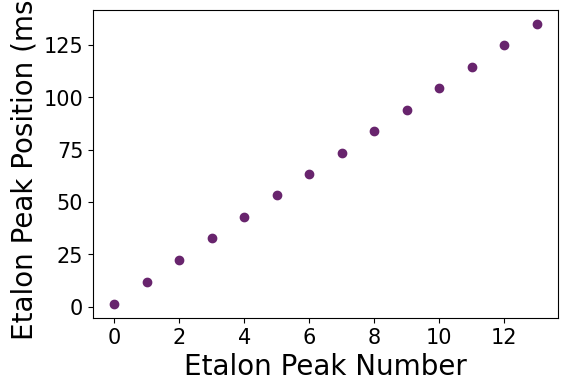

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(Peak_number, np.array(Time_peak)*1e3, 'o')
plt.xticks(np.arange(min(Peak_number), max(Peak_number), 2.0))
#plt.legend(loc='best')
plt.xlabel('Etalon Peak Number')
plt.ylabel('Etalon Peak Position (ms)')
plt.show()

## Fit a linear polynomial to peak position vs etalon peak number as we want our etalons to be equally spaced in frequency space

In [48]:
#Fit linear to peak position and peak number
params1 = [1.0,1.0]
coeffs, matcov = curve_fit(poly1,Peak_number,np.array(Time_peak)*1e3, params1) #fit polynomial regression 1 to the data

A, B = coeffs[0], coeffs[1] # poly1 =a*x + b , so A is coeffs of x(first term=0 in python) and B is coeffs b 

print(A,B)
#print(Peak_number)
#type(Peak_number)

10.260443954401664 1.7186857290425106


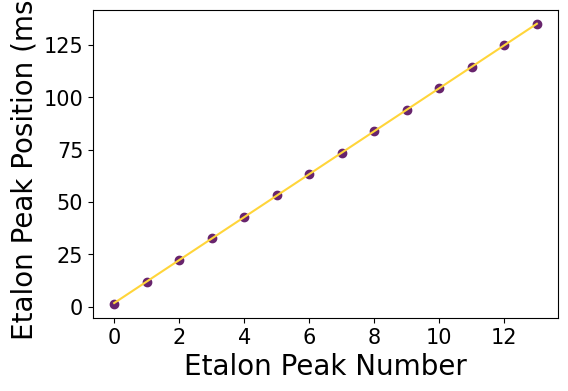

In [49]:

plt.figure(figsize=(6, 4))
plt.plot(Peak_number, np.array(Time_peak)*1e3, 'o')
plt.plot(Peak_number,(A*Peak_number)+B) # poly1=ax+b where x=peak number from above cell to get line

plt.xticks(np.arange(min(Peak_number), max(Peak_number)+1, 2.0))

plt.xlabel('Etalon Peak Number')
plt.ylabel('Etalon Peak Position (ms)')
plt.show()

## Difference between Etalon Peak Postion and Fit

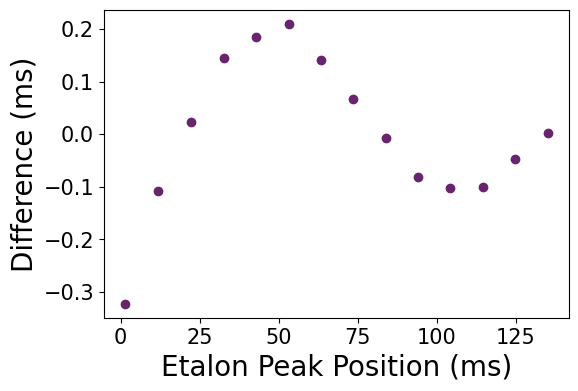

In [50]:
Difference=[]
Difference = np.array(Time_peak)*1e3- ((A*Peak_number)+B)

plt.figure(figsize=(6, 4))

plt.plot(np.array(Time_peak)*1e3,Difference,'o') # make Polynomial regression 1e3(curve) because not all points in figure above is match with line( not linear),so we plot plynomial(degree3)

#plt.xticks(np.arange(min(Peak_number), max(Peak_number)+1, 2.0))

plt.xlabel('Etalon Peak Position (ms)')
plt.ylabel('Difference (ms)')
plt.show()

## We want to fit the difference with a high order polynomial (7th). You may want to use a different order polynomial in which case you will need to change this cell.

In [51]:
#Fit 7th order polynomial to frequency scale 
params7 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
coeffs, matcov = curve_fit(poly7,np.array(Time_peak)*1e3,Difference, params7)

AA, BB, CC, DD,EE,FF,GG,HH= coeffs[0], coeffs[1], coeffs[2], coeffs[3],coeffs[4],coeffs[5],coeffs[6],coeffs[7]
print(AA,BB,CC,DD,EE,FF,GG,HH)

6.098213283946988e-14 -3.163539880776985e-11 6.262231215318122e-09 -5.853232584590483e-07 2.7262740463005145e-05 -0.0008318017970545119 0.02760927745619924 -0.35892416884654227


## Cell below is commented out, but shows how we can change cell above to ouput a 5th order polynomial, for example

In [52]:
'''#Fit 5th order polynomial to frequency scale 
params5 = [1.0,1.0,1.0,1.0,1.0,1.0]
coeffs, matcov = curve_fit(poly5,np.array(Time_peak)*1e3,Difference, params5)

AA, BB, CC, DD,EE,FF= coeffs[0], coeffs[1], coeffs[2], coeffs[3],coeffs[4],coeffs[5]
print(AA,BB,CC,DD,EE,FF)'''

'#Fit 5th order polynomial to frequency scale \nparams5 = [1.0,1.0,1.0,1.0,1.0,1.0]\ncoeffs, matcov = curve_fit(poly5,np.array(Time_peak)*1e3,Difference, params5)\n\nAA, BB, CC, DD,EE,FF= coeffs[0], coeffs[1], coeffs[2], coeffs[3],coeffs[4],coeffs[5]\nprint(AA,BB,CC,DD,EE,FF)'

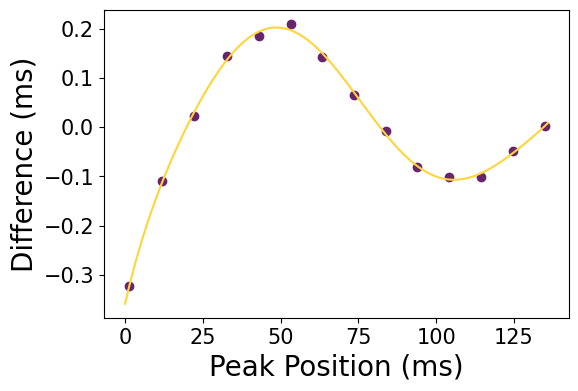

In [53]:
plt.figure(figsize=(6, 4))

plt.plot(Time_peak*1e3,Difference,'o')

plt.plot(Time*1e3,poly7(Time*1e3,*coeffs))


plt.xlabel('Peak Position (ms)')
plt.ylabel('Difference (ms)')
plt.show()

## Correct x axis permanently using our fit for later use. You will also need to edit this if fit polynomial order is changed.

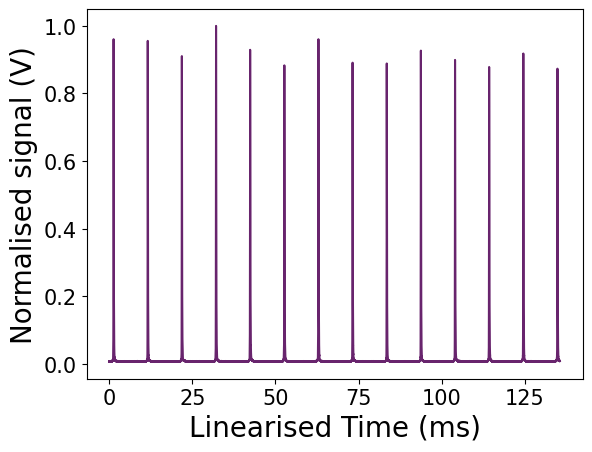

In [54]:
Linearised_Time = Time*1e3 - (AA*((Time*1e3)**7)+BB*((Time*1e3)**6)+CC*((Time*1e3)**5)+DD*((Time*1e3)**4)+EE*((Time*1e3)**3)+FF*((Time*1e3)**2)+GG*((Time*1e3))+HH)
Linearised_Time=Linearised_Time-Linearised_Time[0]

plt.plot((Linearised_Time),Normalised_Etalon)

plt.xlabel('Linearised Time (ms)')
plt.ylabel('Normalised signal (V)')
plt.show()


In [55]:
Linearised_Time

array([0.00000000e+00, 9.72391554e-04, 1.94478477e-03, ...,
       1.35503069e+02, 1.35504063e+02, 1.35505056e+02])

In [56]:
Time

array([0.00000e+00, 1.00000e-06, 2.00000e-06, ..., 1.35870e-01,
       1.35871e-01, 1.35872e-01])

## We now detect the peaks again which are now equally spaced in linearised time. We will use this to determine the peak spacing needed in the next cell. Once again, adjust parameters 'height' and 'distance' as necessary

In [58]:
#print('Detect etalon peaks with minimum height and distance defined')
indexes, _ = signal.find_peaks(Normalised_Etalon, height=0.7, distance=100) 
#print('Peaks are: %s' % (indexes))
findpeak=indexes,_
peakpos = findpeak[0]  #peakpo=peak position
Etalon_peak=[]
Linearised_Time_peak=[]
for n in peakpos:
    y = Normalised_Etalon[n]
    Etalon_peak.append(y)
    x = Linearised_Time[n]
    Linearised_Time_peak.append(x)

## Change x-axis scale to frequency using fact that free spectral range between peaks is constant. You will need to change FSR for your own etalon specifications

10.260438335939746
72.6089837108081


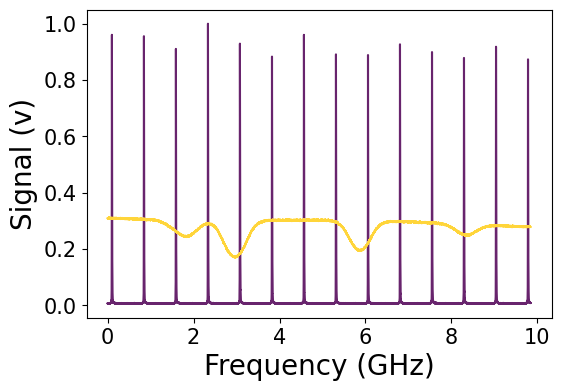

In [59]:
Peak_Spacing = (Linearised_Time_peak[-1] - Linearised_Time_peak[0])/(len(Linearised_Time_peak) - 1) # -1 mean the last number in the array in Python(useful to write -1 for the last number if we do not exactly what the length of your ArrayList is)#len means the length of arraylist(# of peaks)and we take 1 off b/c if we need seperation b/w the peaks which equal to number of peaks -1, so if #of peaks=[1,2,3,4]=3,sperarion b/w them=2 
print(Peak_Spacing)

FSR = 745# units: MHz  #FSR=free spectra range which is the difference in frequency (time) between two normalised peaks[seperation b/w 2 etalon peaks]
Freq_per_time = []
Freq_per_time = FSR/Peak_Spacing #745/peak spacing in time #linearize time axes multiplied by this the conversion factor

print(Freq_per_time)
plt.figure(figsize=(6, 4))
plt.plot(((Linearised_Time*Freq_per_time)/1e3), Normalised_Etalon)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Signal (v)')
plt.plot(((Linearised_Time*Freq_per_time)/1e3), Dopp_Broad_Spec)
plt.show()

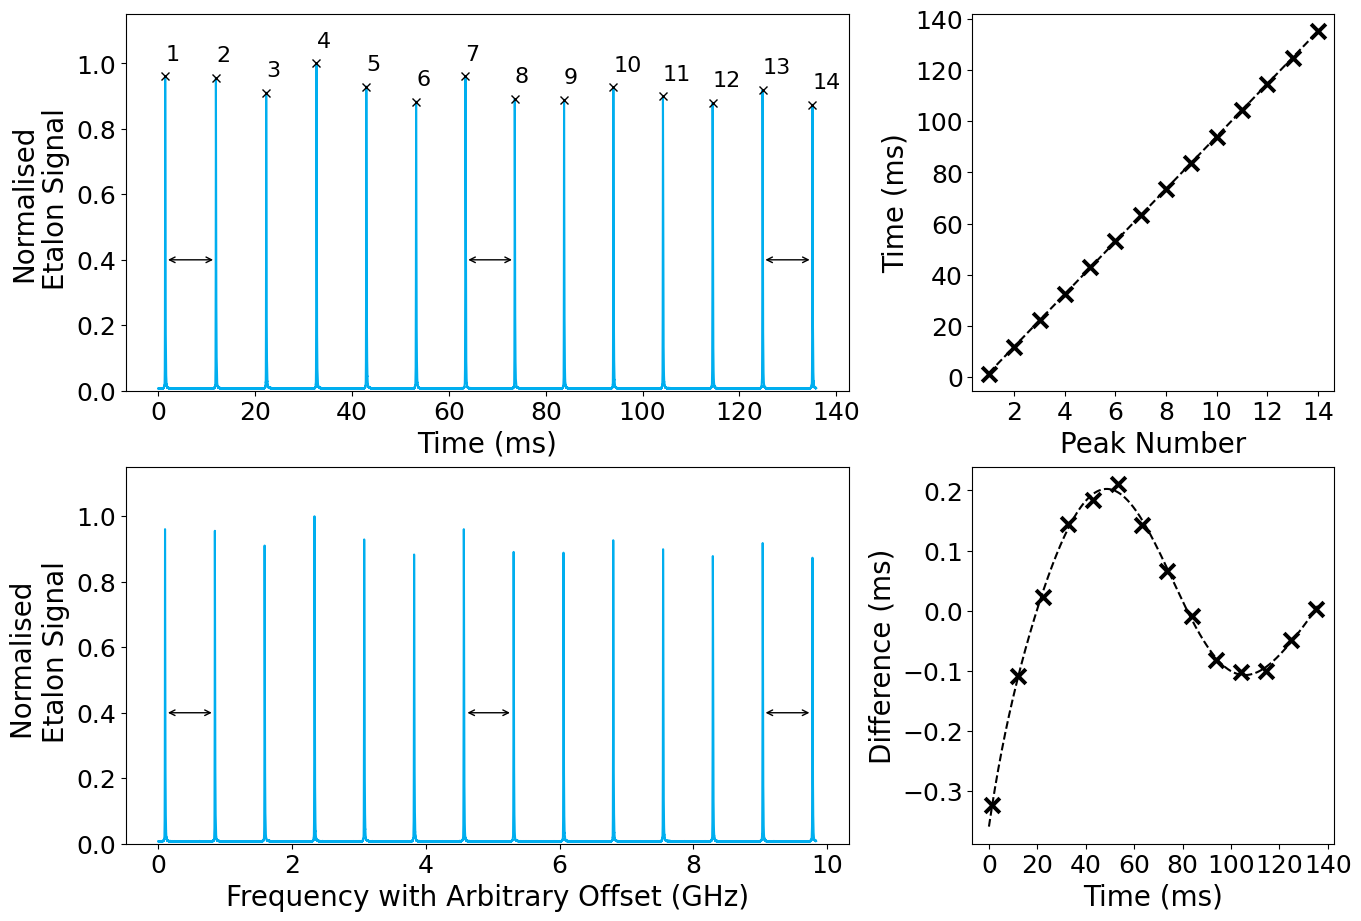

In [60]:
#Figure 8 from Paper
from matplotlib.gridspec import GridSpec
fig=plt.figure(figsize=(9*1.5,7*1.3),constrained_layout=True)
gs = GridSpec(2,6, figure=fig)
ax1 = fig.add_subplot(gs[0,:4])
ax2 = fig.add_subplot(gs[0, 4:6])
ax3 = fig.add_subplot(gs[1, 4:6])
ax4 = fig.add_subplot(gs[1, :4])
#ax1.plot(-1/(Time-0.2)-(-1/(Time[0]-0.2)), Normalised_Etalon,color='#00AEEF')
ax1.plot(Time*1e3, Normalised_Etalon,color='#00AEEF')
ax1.plot(Time_peak*1e3,Etalon_peak,'x',linewidth=5,zorder=2,color='black')
ax2.scatter(Peak_number+1, np.array(Time_peak)*1e3,s=4,color='black',marker='x',zorder=2,lw=15)
ax2.plot(Peak_number+1,(A*Peak_number)+B,color='black',linestyle='dashed',zorder=1)
ax3.scatter(Time_peak*1e3,Difference,s=4,marker='x',color='black',zorder=2,lw=15)
ax3.plot(Time*1e3,poly7(Time*1e3,*coeffs),color='black',zorder=1,linestyle='dashed')
ax1.set_ylim(0,1.15)
ax4.set_ylim(0,1.15)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Normalised\n Etalon Signal',fontsize=20)
ax2.set_ylabel('Time (ms)',fontsize=20)
ax2.set_xlabel('Peak Number',fontsize=20)
ax2.set_xticks([2,4,6,8,10,12,14])
ax2.set_yticks([0,20,40,60,80,100,120,140])
ax3.set_xticks([0,20,40,60,80,100,120,140])
ax3.set_xlabel('Time (ms)',fontsize=20)
ax3.set_ylabel('Difference (ms)',fontsize=20)
ax4.plot(((Linearised_Time*Freq_per_time)/1e3), Normalised_Etalon,color='#00AEEF')
ax4.set_xlabel('Frequency with Arbitrary Offset (GHz)')
ax4.set_ylabel('Normalised \n Etalon Signal')
n=range(1,15)
for i, txt in enumerate(n):
    ax1.annotate(txt, (Time_peak[i]*1e3-Time[0]*1e3, Etalon_peak[i]+0.05),fontsize=16)
ax4.annotate(text='', xy=(0.10,0.4), xytext=(0.84,0.4), arrowprops=dict(arrowstyle='<->'))
ax4.annotate(text='', xy=(4.58,0.4), xytext=(5.30,0.4), arrowprops=dict(arrowstyle='<->'))
ax4.annotate(text='', xy=(9.04,0.4), xytext=(9.78,0.4), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(text='', xy=(Time_peak[0]*1e3,0.4), xytext=(Time_peak[1]*1e3,0.4), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(text='', xy=(Time_peak[12]*1e3,0.4), xytext=(Time_peak[13]*1e3,0.4), arrowprops=dict(arrowstyle='<->'))
ax1.annotate(text='', xy=(Time_peak[6]*1e3,0.4), xytext=(Time_peak[7]*1e3,0.4), arrowprops=dict(arrowstyle='<->'))
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax4.tick_params(axis='both', which='major', labelsize=18)

## Step 3: Removing the power fluctuations on the sub doppler trace for easier absolute frequency calibration. (Follows Section 3.2)

## Select points either side of absorption troughs.

In [61]:
'''
%matplotlib
plt.plot(Linearised_Time*Freq_per_time,Sub_Dopp_Zeroed)


#Collect mouse input
print(r'Select either side of atomic resonance')
x_sub_dopp = plt.ginput(7) #Select points either side of absorption troughs.

plt.show(block=False)
plt.close()'''


"\n%matplotlib\nplt.plot(Linearised_Time*Freq_per_time,Sub_Dopp_Zeroed)\n\n\n#Collect mouse input\nprint(r'Select either side of atomic resonance')\nx_sub_dopp = plt.ginput(7) #Select points either side of absorption troughs.\n\nplt.show(block=False)\nplt.close()"

## Points Used in Paper 

In [62]:
x_sub_dopp=[(1035.4632403415858, 0.56511347),
 (3712.0629829359273, 0.56778205),
 (5137.643280622044, 0.56968818),
 (6570.496947173906, 0.56473224),
 (7726.9625968274395, 0.55367668),
 (9094.355943587592, 0.53728394)]

Text(0, 0.5, 'Photodiode Output (V)')

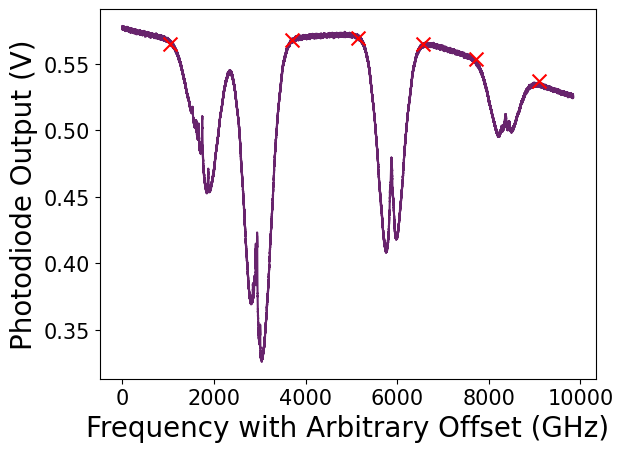

In [63]:
%matplotlib inline
for i in x_sub_dopp:
    plt.scatter(i[0],i[1],s=100,marker='x',zorder=2,color='red')
plt.plot(Linearised_Time*Freq_per_time,Sub_Dopp,zorder=1)
plt.xlabel('Frequency with Arbitrary Offset (GHz)')
plt.ylabel('Photodiode Output (V)')

## Define one regions

Text(0, 0.5, 'Signal (V)')

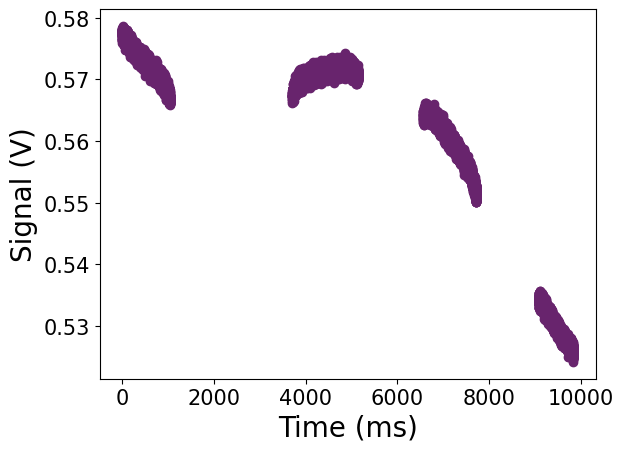

In [64]:
a = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_sub_dopp[0][0]))
b = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_sub_dopp[1][0]))
c = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_sub_dopp[2][0]))
d = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_sub_dopp[3][0]))
e = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_sub_dopp[4][0]))
f = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_sub_dopp[5][0]))

offResX = np.append(Linearised_Time[:a]*Freq_per_time, Linearised_Time[b:c]*Freq_per_time) # background from begining to point a then from c to d (b not include b/c there is no line there)
offResX = np.append(offResX,Linearised_Time[d:e]*Freq_per_time) # include all line before e and line e to f and exclude the rest
offResX = np.append(offResX,Linearised_Time[f:]*Freq_per_time)

offResTrace = np.append(Sub_Dopp[:a], Sub_Dopp[b:c])
offResTrace = np.append(offResTrace,Sub_Dopp[d:e])
offResTrace = np.append(offResTrace,Sub_Dopp[f:])

plt.plot(offResX,offResTrace,'o')
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')


Text(0, 0.5, 'Signal (V)')

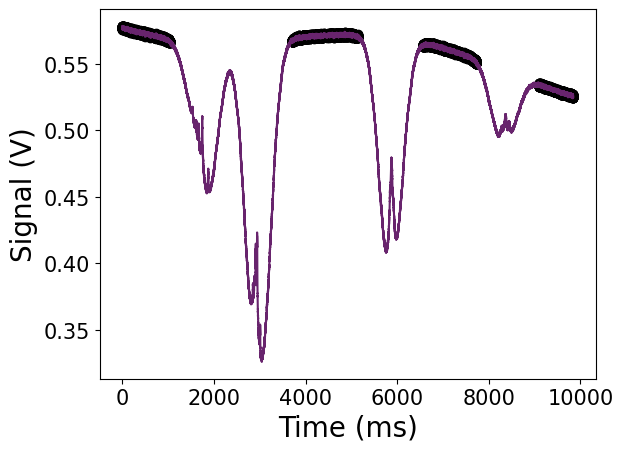

In [65]:
## This plot shows us what we're going to include in the model to fit to the background so that we can normalise the transmission
# stright line is background
plt.plot(offResX,offResTrace,'ok')
plt.plot(Linearised_Time*Freq_per_time,Sub_Dopp)
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')

## We fit with a fifth order polynomial, cell contains commented out code for other polynomial fits

In [66]:
#Fit cubic to frequency scale
#IN THIS CASE, we have chosen to fit with a fifth order polynomial.
#params12 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
#params11 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
#params10 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
#params9 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
#params8 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
#params7 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
#params6 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0]
params5 = [1.0,1.0,1.0,1.0,1.0,1.0]
#params4 = [1.0,1.0,1.0,1.0,1.0]
#params3 = [1.0,1.0,1.0,1.0]
#params2 = [1.0,1.0,1.0]
#params1=[1.0,1.0]

coeffs, matcov = curve_fit(poly5,offResX,offResTrace, params5)
#coeffs, matcov = curve_fit(poly12,offResX,offResTrace, params12)
#coeffs, matcov = curve_fit(poly11,offResX,offResTrace, params11)
#coeffs, matcov = curve_fit(poly10,offResX,offResTrace, params10)
#coeffs, matcov = curve_fit(poly9,offResX,offResTrace, params9)
#coeffs, matcov = curve_fit(poly8,Linearised_Time[start:finish],Spec[start:finish], params8)
#coeffs, matcov = curve_fit(poly7,Linearised_Time[start:finish],Spec[start:finish], params7)
#coeffs, matcov = curve_fit(poly6,Linearised_Time[start:finish],Spec[start:finish], params6)
#coeffs, matcov = curve_fit(poly5,Linearised_Time[start:finish],Spec[start:finish], params5)
#coeffs, matcov = curve_fit(poly4,Linearised_Time[start:finish],Spec[start:finish], params4)
#coeffs, matcov = curve_fit(poly3,Linearised_Time[start:finish],Spec[start:finish], params3)
#coeffs, matcov = curve_fit(poly2,Linearised_Time[start:finish],Spec[start:finish], params2)
#coeffs, matcov = curve_fit(poly1,offResX,offResTrace, params1)


#A, B, C, D, E, F, G, H, I, J,K,L,M = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7], coeffs[8], coeffs[9],coeffs[10],coeffs[11],coeffs[12]
#print(A,B,C,D,E,F,G,H,I,J)

#A, B, C, D, E, F, G, H, I, J,K,L = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7], coeffs[8], coeffs[9],coeffs[10],coeffs[11]
#print(A,B,C,D,E,F,G,H,I,J)

#A, B, C, D, E, F, G, H, I, J,K = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7], coeffs[8], coeffs[9],coeffs[10]
#print(A,B,C,D,E,F,G,H,I,J)

#A, B, C, D, E, F, G, H, I, J = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7], coeffs[8], coeffs[9]
#print(A,B,C,D,E,F,G,H,I,J)

#A, B, C, D, E, F, G, H, I = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7], coeffs[8]
#print(A,B,C,D,E,F,G,H,I)

#A, B, C, D, E, F, G, H = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7]
#print(A,B,C,D,E,F,G,H)

#A, B, C, D, E, F, G = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6]
#print(A,B,C,D,E,F,G)

A, B, C, D, E, F = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5]
#print(A,B,C,D,E,F)

#A, B, C, D, E = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4]
#print(A,B,C,D,E)

#A, B, C, D = coeffs[0], coeffs[1], coeffs[2], coeffs[3]
#print(A,B,C,D)

#A, B, C = coeffs[0], coeffs[1], coeffs[2]
#print(A,B,C)

#A, B = coeffs[0], coeffs[1]
#print(A,B)

Text(0, 0.5, 'Signal (V)')

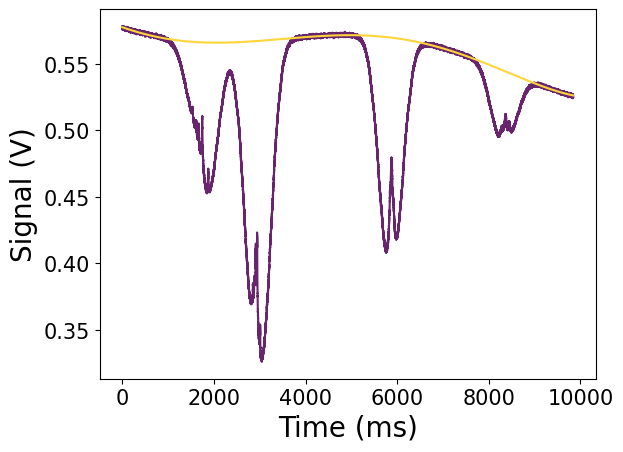

In [67]:
## This plot shows us what our data (blue) and fit to background (orange) look like
plt.plot(Linearised_Time*Freq_per_time,Sub_Dopp)
plt.plot(Linearised_Time*Freq_per_time,poly5(Linearised_Time*Freq_per_time,*coeffs))
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')
#plt.plot(Linearised_Time,poly2(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,poly3(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,poly4(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,poly5(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,poly6(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,poly7(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,poly8(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,poly9(Linearised_Time,*coeffs))
#plt.plot(Linearised_Time,Spec-poly9(Linearised_Time,*coeffs))


## Sub Doppler Spectrum with corrected one. Note this is not normalised fully as has non-zero offset. For our purposes we do not need a fully normalised transmission

Text(0, 0.5, 'Signal (V)')

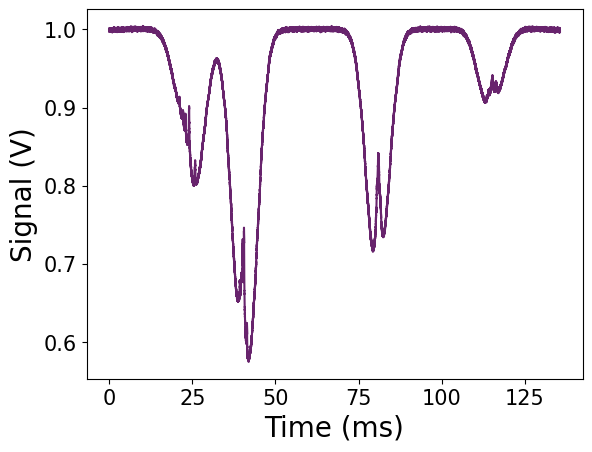

In [68]:
plt.plot(Linearised_Time,Sub_Dopp/poly5(Linearised_Time*Freq_per_time,*coeffs))
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')

## Step 4: Absolute Frequency Calibration: We choose sub doppler features on graph and compare to known detuning values. (Follows Section 3.3) 

## Since the features are small, we first define regions to zoom in on. Place a point before and after regions of interest.

In [69]:
'''
#Pick Peaks in 1st Absorption Region
import matplotlib.pyplot as plt
%matplotlib

plt.plot(range(0,len(Linearised_Time)),Sub_Dopp)


#Collect mouse input
print(r'Select either side of absorption trough')
x_cuts = plt.ginput(8)

plt.show(block=False)
plt.close()'''

"\n#Pick Peaks in 1st Absorption Region\nimport matplotlib.pyplot as plt\n%matplotlib\n\nplt.plot(range(0,len(Linearised_Time)),Sub_Dopp)\n\n\n#Collect mouse input\nprint(r'Select either side of absorption trough')\nx_cuts = plt.ginput(8)\n\nplt.show(block=False)\nplt.close()"

In [70]:
x_cuts=[(19221.139784946237, 0.5327657131482988),
 (27859.23870967742, 0.46720791497669234),
 (38204.8688172043, 0.3859315804013672),
 (43427.90537634408, 0.34337651843032435),
 (79888.7182795699, 0.4162185163987761),
 (83002.45161290324, 0.4204356847022128),
 (112934.46881720432, 0.496344714164073),
 (118057.06236559141, 0.50247877715089)]

Text(0, 0.5, 'Photodiode Output (V)')

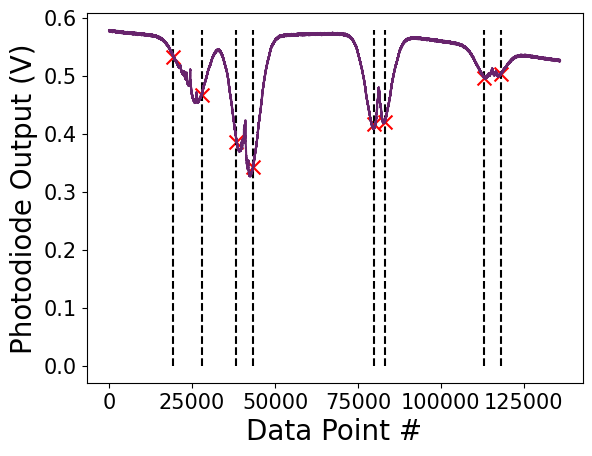

In [71]:
%matplotlib inline
for i in x_cuts:
    plt.scatter(i[0],i[1],s=100,marker='x',zorder=2,color='red')
    plt.vlines(i[0],0,max(Sub_Dopp),linestyle='dashed',color='black')
plt.plot(range(0,len(Linearised_Time)),Sub_Dopp)
plt.xlabel('Data Point #')
plt.ylabel('Photodiode Output (V)')

## Pick as many sub-doppler features as are clear enough to pinpoint. Change g-input value n to number of sub-doppler positions features being picked

In [72]:
'''
#Pick Peaks in 1st Absorption Region
%matplotlib
n=6
x_firstpeak=[]
plt.plot(Linearised_Time[int(x_cuts[0][0]):int(x_cuts[1][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[0][0]):int(x_cuts[1][0])])



#Collect mouse input
print(r'Select either side of atomic resonance')
x_points1 = plt.ginput(n)

plt.show(block=False)
plt.close()
for i in range(0,n):
    peak_position1 = x_points1[i][0]
    x_firstpeak = np.append(x_firstpeak,peak_position1)'''

"\n#Pick Peaks in 1st Absorption Region\n%matplotlib\nn=6\nx_firstpeak=[]\nplt.plot(Linearised_Time[int(x_cuts[0][0]):int(x_cuts[1][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[0][0]):int(x_cuts[1][0])])\n\n\n\n#Collect mouse input\nprint(r'Select either side of atomic resonance')\nx_points1 = plt.ginput(n)\n\nplt.show(block=False)\nplt.close()\nfor i in range(0,n):\n    peak_position1 = x_points1[i][0]\n    x_firstpeak = np.append(x_firstpeak,peak_position1)"

In [73]:
'''
#Pick Peaks in 2nd Absorption Region
%matplotlib
n=6
x_secondpeak=[]
plt.plot(Linearised_Time[int(x_cuts[2][0]):int(x_cuts[3][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[2][0]):int(x_cuts[3][0])])

#Collect mouse input
print(r'Select either side of atomic resonance')
x_points2 =plt.ginput(6) 

plt.show(block=False)
plt.close()
for i in range(0,n):
    peak_position2 = x_points2[i][0]
    x_secondpeak = np.append(x_secondpeak,peak_position2)'''

"\n#Pick Peaks in 2nd Absorption Region\n%matplotlib\nn=6\nx_secondpeak=[]\nplt.plot(Linearised_Time[int(x_cuts[2][0]):int(x_cuts[3][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[2][0]):int(x_cuts[3][0])])\n\n#Collect mouse input\nprint(r'Select either side of atomic resonance')\nx_points2 =plt.ginput(6) \n\nplt.show(block=False)\nplt.close()\nfor i in range(0,n):\n    peak_position2 = x_points2[i][0]\n    x_secondpeak = np.append(x_secondpeak,peak_position2)"

In [74]:
'''
#Pick Peaks in 3rd Absorption Region
%matplotlib
n=6
x_thirdpeak=[]
plt.plot(Linearised_Time[int(x_cuts[4][0]):int(x_cuts[5][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[4][0]):int(x_cuts[5][0])])

#Collect mouse input
print(r'Select either side of atomic resonance')
x_points3 = plt.ginput(6) 

plt.show(block=False)
plt.close()
for i in range(0,n):
    peak_position3 = x_points3[i][0]
    x_thirdpeak = np.append(x_thirdpeak,peak_position3)'''

"\n#Pick Peaks in 3rd Absorption Region\n%matplotlib\nn=6\nx_thirdpeak=[]\nplt.plot(Linearised_Time[int(x_cuts[4][0]):int(x_cuts[5][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[4][0]):int(x_cuts[5][0])])\n\n#Collect mouse input\nprint(r'Select either side of atomic resonance')\nx_points3 = plt.ginput(6) \n\nplt.show(block=False)\nplt.close()\nfor i in range(0,n):\n    peak_position3 = x_points3[i][0]\n    x_thirdpeak = np.append(x_thirdpeak,peak_position3)"

In [75]:
'''
#Pick Peaks in 4th Absorption Region
%matplotlib
n=6
x_fourthpeak=[]
plt.plot(Linearised_Time[int(x_cuts[6][0]):int(x_cuts[7][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[6][0]):int(x_cuts[7][0])])


#Collect mouse input
print(r'Select either side of atomic resonance')
x_points4 = plt.ginput(6) 

plt.show(block=False)
plt.close()

for i in range(0,n):
    peak_position4 = x_points4[i][0]
    x_fourthpeak = np.append(x_fourthpeak,peak_position4)'''

"\n#Pick Peaks in 4th Absorption Region\n%matplotlib\nn=6\nx_fourthpeak=[]\nplt.plot(Linearised_Time[int(x_cuts[6][0]):int(x_cuts[7][0])]*Freq_per_time/1e3,Sub_Dopp[int(x_cuts[6][0]):int(x_cuts[7][0])])\n\n\n#Collect mouse input\nprint(r'Select either side of atomic resonance')\nx_points4 = plt.ginput(6) \n\nplt.show(block=False)\nplt.close()\n\nfor i in range(0,n):\n    peak_position4 = x_points4[i][0]\n    x_fourthpeak = np.append(x_fourthpeak,peak_position4)"

## We store all our detected sub doppler features in this array

In [76]:
#Sub_doppler_detected_peaks=[]
#Sub_doppler_detected_peaks=np.append(Sub_doppler_detected_peaks,x_firstpeak)
#Sub_doppler_detected_peaks=np.append(Sub_doppler_detected_peaks,x_secondpeak)
#Sub_doppler_detected_peaks=np.append(Sub_doppler_detected_peaks,x_thirdpeak)
#Sub_doppler_detected_peaks=np.append(Sub_doppler_detected_peaks,x_fourthpeak)
#print(Sub_doppler_detected_peaks)
Sub_doppler_detected_peaks=np.array([1.878,1.7460,1.6687,1.6118,1.5344,1.4542,2.8238,2.8533,2.8842,2.9150,2.9436,3.0084,8.4416,8.3637,8.3376,8.2853,8.2499,8.2172,5.8740,5.9057,5.8423,5.8130,5.8277,5.8594])

## Detuning Values taken from Siddons 2008 paper in GHz, comment out unused frequencies as necessary. For Na, K or Cs values please consult one of the theory packages.

In [77]:
#from Siddons 2008 paper in GHz, comment out unused frequencies as necessary.
firstpeak_absolute=np.array([-2.73505,-2.57811,-2.31126,(-2.73505+-2.57811)/2,(-2.57811+-2.31126)/2,(-2.73505+-2.31126)/2])
secondpeak_absolute=np.array([-1.37129,-1.30787,-1.18691,(-1.37129+-1.30787)/2,(-1.30787+-1.18691)/2,(-1.37129+-1.18691)/2])
thirdpeak_absolute=np.array([1.635454, 1.664714, 1.728134,(1.635454+1.664714)/2,(1.664714+1.728134)/2,(1.635454+1.728134)/2])
fourthpeak_absolute=np.array([4.027403,4.099625,4.2565,(4.027403+4.099625)/2,(4.099625+4.2565)/2,(4.027403+4.2565)/2])
Absolute_Detunings=[]
Absolute_Detunings=np.append(Absolute_Detunings,firstpeak_absolute)
Absolute_Detunings=np.append(Absolute_Detunings,secondpeak_absolute)
Absolute_Detunings=np.append(Absolute_Detunings,thirdpeak_absolute)
Absolute_Detunings=np.append(Absolute_Detunings,fourthpeak_absolute)

## Fit Detected Sub_Doppler Peaks vs Absolute Detunings. Y-intercept BBB is shift required to transform from arbitrary frequency axis to detuning. AAA shows deviation from linearity

In [78]:
#Fit linear to peak position and peak number
params1 = [1.0,1.0]
Absolute_Detunings=np.sort(Absolute_Detunings)
Sub_doppler_detected_peaks=np.sort(Sub_doppler_detected_peaks)
coefffs, matcov = curve_fit(poly1,Sub_doppler_detected_peaks,Absolute_Detunings,params1) #fit polynomial regression 1 to the data

AAA, BBB = coefffs[0], coefffs[1] # poly1 =a*x + b , so A is coeffs of x(first term=0 in python) and B is coeffs b 

print(AAA,BBB)
#print(Peak_number)
#type(Peak_number)

1.0010668772751437 -4.192332154701537


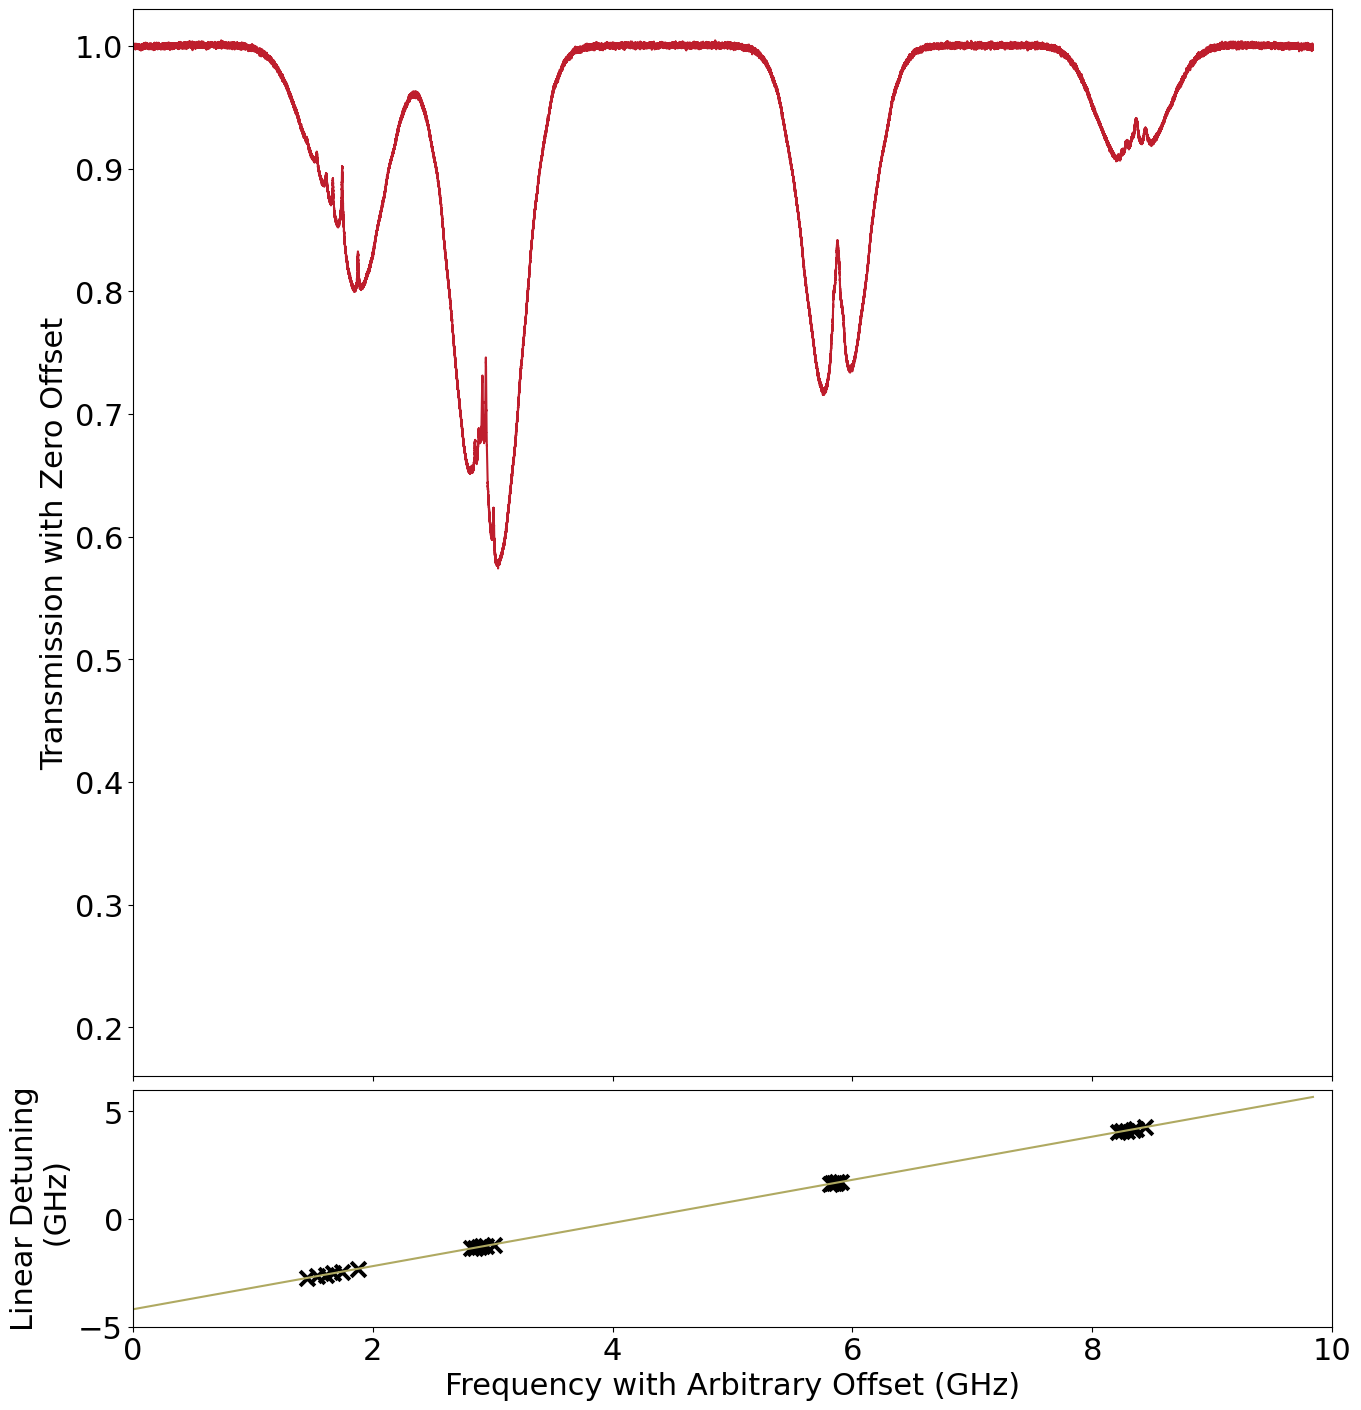

In [79]:
#Figure 10 from Paper
from matplotlib.gridspec import GridSpec
fig=plt.figure(figsize=(9*1.5,9*1.3*1.5),constrained_layout=True)
gs = GridSpec(14,2, figure=fig)
#ax1 = fig.add_subplot(gs[0:3,0])
#ax2 = fig.add_subplot(gs[0:3,1],sharey=ax1)
ax3 = fig.add_subplot(gs[3:12, :2])
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = fig.add_subplot(gs[12:14,:2],sharex=ax3)
ax1.plot(offResX/1e3,offResTrace,'o',color='black',rasterized=True)
ax1.plot(Linearised_Time*Freq_per_time/1e3,Sub_Dopp,'#BE1E2D')
ax2.plot(Linearised_Time*Freq_per_time/1e3,Sub_Dopp,'#BE1E2D',zorder=1)
ax2.plot(Linearised_Time*Freq_per_time/1e3,poly5(Linearised_Time*Freq_per_time,*coeffs),'black',linestyle='dashed',zorder=2,lw=2,rasterized=True)
ax3.plot(((Linearised_Time*Freq_per_time)/1e3),Sub_Dopp/poly5(Linearised_Time*Freq_per_time,*coeffs),color='#BE1E2D')
ax4.scatter(Sub_doppler_detected_peaks,Absolute_Detunings,marker='x',s=4,color='black',zorder=2,lw=15)
ax4.plot(Linearised_Time*Freq_per_time/1e3,AAA*Linearised_Time*Freq_per_time/1e3+BBB,'#AFA961',zorder=2)
ax4.set_xlim(0,10)
ax4.set_ylim(-5,6)
#ax4.set_yticks([-4,0,4])
ax3.set_ylim([0.16,1.03])
ax1.set_ylabel('Photodiode\n Output (V)',fontsize=22)
ax1.set_xlabel('Frequency with Arbitrary Offset (GHz)',fontsize=22)
ax2.set_xlabel('Frequency with Arbitrary Offset (GHz)',fontsize=22)
ax4.set_xlabel('Frequency with Arbitrary Offset (GHz)',fontsize=22)
ax4.set_ylabel('Linear Detuning\n (GHz)',fontsize=22)
ax3.set_ylabel('Transmission with Zero Offset',fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=22)
ax2.tick_params(axis='both', which='major', labelsize=22)
ax3.tick_params(axis='both', which='major', labelsize=22)
ax4.tick_params(axis='both', which='major', labelsize=22)


## Smoothing function for insets

In [80]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

## Smoothing for Zoom-in insets. We use smaller smoothing weight for fourth absorption peak as peaks are on par with noise and we want to avoid over smoothing.

In [81]:
Sub_Dopp_smooth100=smoothTriangle(Sub_Dopp,100)
Sub_Dopp_smooth70=smoothTriangle(Sub_Dopp,70)

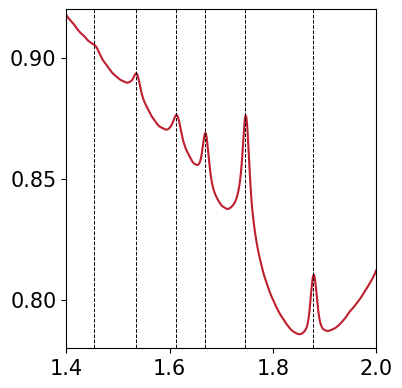

In [82]:
#1st Absorption Peak
plt.subplots(figsize=(5*0.8,5.5*0.8))
plt.plot(Linearised_Time*Freq_per_time/1e3+0.005,Sub_Dopp_smooth100/poly5(Linearised_Time*Freq_per_time/1e3,*coeffs),'#BE1E2D')
# Smoothing causes y_data to be shifted vs x_data so we add 0.005 but this smoothed data is not used going forward
plt.xlim([1.4,2]) 
plt.ylim(0.78,0.92)
plt.yticks([0.8,0.85,0.9])
for i in Sub_doppler_detected_peaks[0:6]:
   plt.vlines(i,0.75,0.95,linestyle='dashed',color='black',lw=0.7)


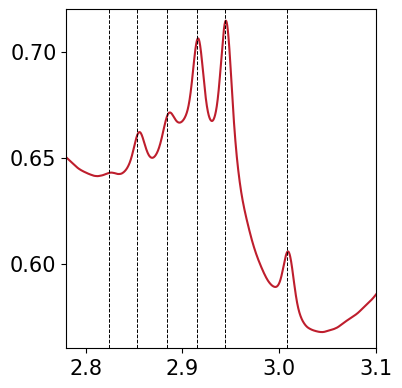

In [83]:
#2nd Absorption Peak
plt.subplots(figsize=(5*0.8,5.5*0.8))
plt.plot(Linearised_Time*Freq_per_time/1e3+0.005,Sub_Dopp_smooth100/poly5(Linearised_Time*Freq_per_time/1e3,*coeffs),'#BE1E2D')
plt.yticks([0.6,0.65,0.7])
plt.ylim(0.56,0.72)
plt.xlim(2.78,3.1)
for i in Sub_doppler_detected_peaks[6:12]:
   plt.vlines(i,0.56,0.75,linestyle='dashed',color='black',lw=0.7)


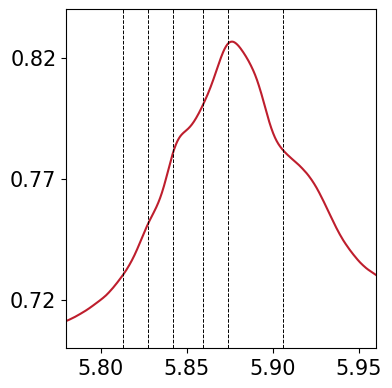

In [84]:
#3rd Absorption Peak
plt.subplots(figsize=(5*0.8,5.5*0.8))
plt.plot(Linearised_Time*Freq_per_time/1e3+0.005,Sub_Dopp_smooth100/poly5(Linearised_Time*Freq_per_time/1e3,*coeffs),'#BE1E2D')
plt.ylim([0.70,0.84])
plt.xlim(5.78,5.96)

plt.yticks([0.72,0.77,0.82])
for i in Sub_doppler_detected_peaks[12:18]:
   plt.vlines(i,0.70,0.85,linestyle='dashed',color='black',lw=0.7)


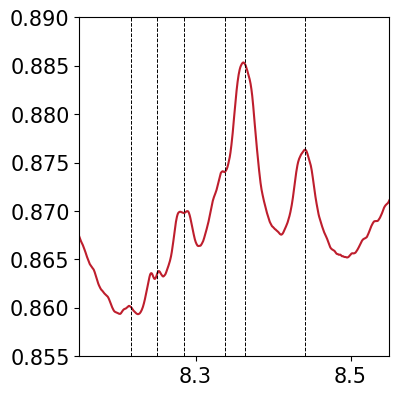

In [85]:
#4th Absorption Peak
plt.subplots(figsize=(5*0.8,5.5*0.8))
plt.plot(Linearised_Time*Freq_per_time/1e3,Sub_Dopp_smooth70/poly5(Linearised_Time*Freq_per_time/1e3,*coeffs),'#BE1E2D')
plt.ylim(0.855,0.89)
plt.xlim(8.15,8.55)
plt.xticks([8.3,8.5])
for i in Sub_doppler_detected_peaks[18:24]:
   plt.vlines(i,0.855,0.89,linestyle='dashed',color='black',lw=0.7)


## Step 5: Normalising Doppler Broadened/Experiment Spectrum. (Follows Section 3.2)

## Zeroing the Spectrum. For info on how we obtain Zero see Appendix of Notebook

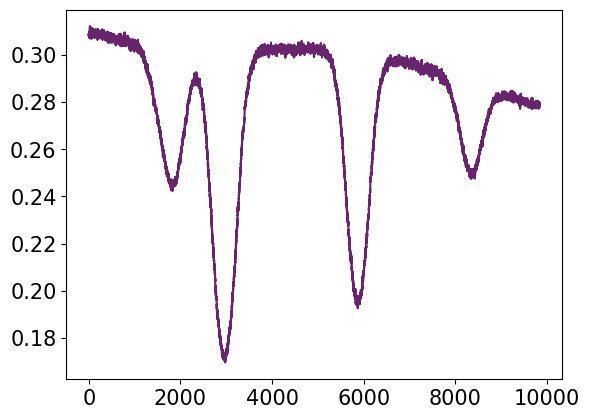

In [86]:
plt.plot(Linearised_Time*Freq_per_time,Dopp_Broad_Spec)
Zero=(-0.00046452752822592503*Linearised_Time/1e3*Freq_per_time+ 0.05549039777557824)
Dopp_Broad_Spec_Zeroed=Dopp_Broad_Spec-Zero


## We choose points either side of absorption peaks

In [87]:
'''
%matplotlib
plt.plot(Linearised_Time*Freq_per_time,Dopp_Broad_Spec_Zeroed)


#Collect mouse input
print(r'Select either side of atomic resonance')
x_dopp_broad = plt.ginput(6) #b/c we have 7 points b/w dips, should be 8 but for my data 3 dips so close to eachoter so we do not need to select two points

plt.show(block=False)
plt.close()
'''

"\n%matplotlib\nplt.plot(Linearised_Time*Freq_per_time,Dopp_Broad_Spec_Zeroed)\n\n\n#Collect mouse input\nprint(r'Select either side of atomic resonance')\nx_dopp_broad = plt.ginput(6) #b/c we have 7 points b/w dips, should be 8 but for my data 3 dips so close to eachoter so we do not need to select two points\n\nplt.show(block=False)\nplt.close()\n"

## Points Used in Paper

In [88]:
x_dopp_broad=[(1064.556716627084, 0.24846527746397118),
 (3748.4298301608305, 0.24696917181031855),
 (5137.643284591577, 0.24761035994759825),
 (6592.31705886461, 0.24525933677757267),
 (7719.68923392621, 0.23884745540477562),
 (9116.176057228324, 0.23051200962013946)]


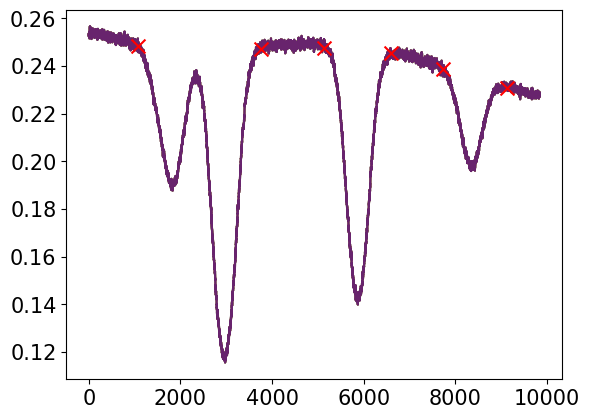

In [89]:
%matplotlib inline
for i in x_dopp_broad:
    plt.scatter(i[0],i[1],s=100,marker='x',zorder=2,color='red')
    plt.plot(Linearised_Time*Freq_per_time,Dopp_Broad_Spec_Zeroed,zorder=1)

## Define One Regions

Text(0, 0.5, 'Signal (V)')

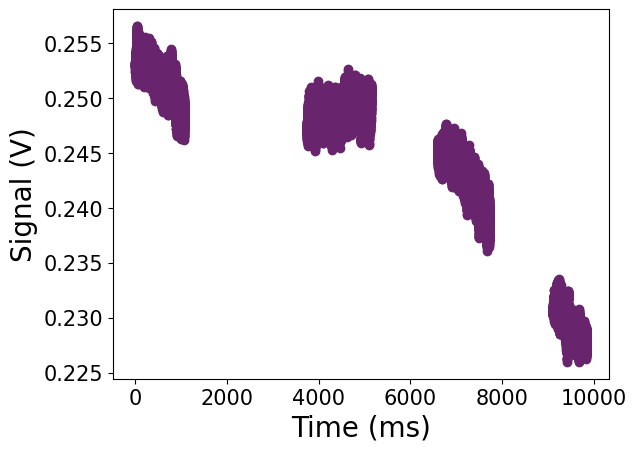

In [90]:
a = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_dopp_broad[0][0]))
b = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_dopp_broad[1][0]))
c = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_dopp_broad[2][0]))
d = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_dopp_broad[3][0]))
e = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_dopp_broad[4][0]))
f = np.argmin(np.abs(Linearised_Time*Freq_per_time - x_dopp_broad[5][0]))

offResX = np.append(Linearised_Time[:a]*Freq_per_time, Linearised_Time[b:c]*Freq_per_time) 
offResX = np.append(offResX,Linearised_Time[d:e]*Freq_per_time)
offResX = np.append(offResX,Linearised_Time[f:]*Freq_per_time)

offResTrace = np.append(Dopp_Broad_Spec_Zeroed[:a], Dopp_Broad_Spec_Zeroed[b:c])
offResTrace = np.append(offResTrace,Dopp_Broad_Spec_Zeroed[d:e])
offResTrace = np.append(offResTrace,Dopp_Broad_Spec_Zeroed[f:])

plt.plot(offResX,offResTrace,'o')
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')


Text(0, 0.5, 'Signal (V)')

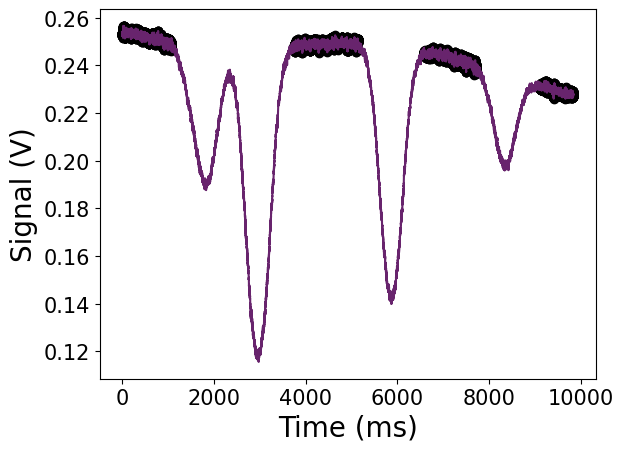

In [91]:
plt.plot(offResX,offResTrace,'ok')
plt.plot(Linearised_Time*Freq_per_time,Dopp_Broad_Spec_Zeroed)
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')

## Fitting the one with a polynomial. Change polynomial order as needed.

In [92]:
params5 = [1.0,1.0,1.0,1.0,1.0,1.0]

coeffs, matcov = curve_fit(poly5,offResX,offResTrace, params5)

A, B, C, D, E, F = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5]

In [93]:
'''params7 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]

coeffs, matcov = curve_fit(poly7,offResX,offResTrace, params7)

A, B, C, D, E, F, G ,H = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7]'''

'params7 = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]\n\ncoeffs, matcov = curve_fit(poly7,offResX,offResTrace, params7)\n\nA, B, C, D, E, F, G ,H = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6], coeffs[7]'

([<matplotlib.axis.XTick at 0x7fdb0b683050>,
 [Text(0, 0, '0'), Text(5, 0, '5'), Text(10, 0, '10')])

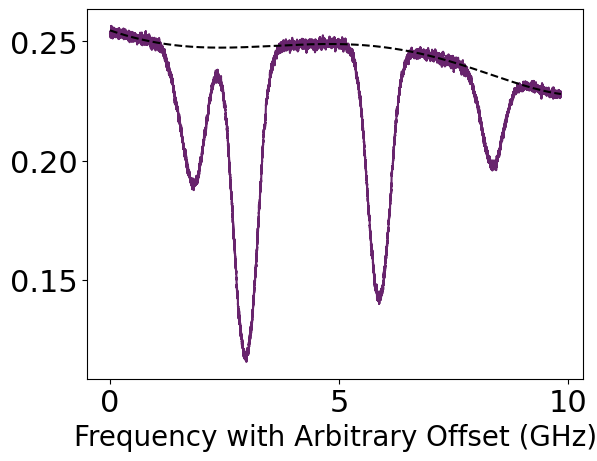

In [94]:
## b) from Figure 9
%matplotlib inline
plt.plot(Linearised_Time*Freq_per_time/1e3,Dopp_Broad_Spec_Zeroed)
plt.plot(Linearised_Time*Freq_per_time/1e3,poly5(Linearised_Time*Freq_per_time,*coeffs),color='black',zorder=2,linestyle='dashed')
plt.xlabel('Frequency with Arbitrary Offset (GHz)')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks([0,5,10])

## Normalised Room Temperature Spectrum with calibrated detuning axis

Text(0.5, 0, 'Linear Detuning (GHz)')

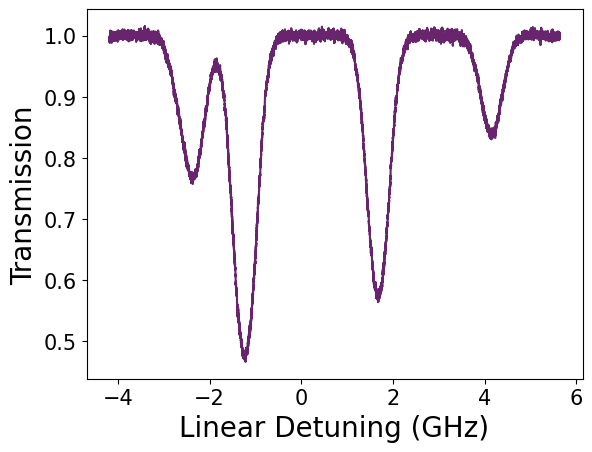

In [95]:
Norm_Spec = Dopp_Broad_Spec_Zeroed/poly5(Linearised_Time*Freq_per_time,*coeffs)
plt.plot(Linearised_Time*Freq_per_time/1e3+BBB,Norm_Spec)
plt.ylabel('Transmission')
plt.xlabel('Linear Detuning (GHz)')

## Step 6: Fitting to Theory. We use ElecSus as an example but data could also be fitted using ADM or the Antoine Weis Mathematica program. (Follows Section 4)

## We bin the data including data measured at 40C and 73C, already linearised and normalised, which we imported earlier.

In [96]:
from scipy.stats import binned_statistic
Vals_40 = binned_statistic(Dopp_Broad_Spec_2_Norm_Detunings,Dopp_Broad_Spec_2_Norm_Vals, statistic='mean',bins=800)[0]
Time_40 = binned_statistic(Dopp_Broad_Spec_2_Norm_Detunings,Dopp_Broad_Spec_2_Norm_Detunings, statistic='mean', bins=800)[0]
Vals_73= binned_statistic(Dopp_Broad_Spec_3_Norm_Detunings,Dopp_Broad_Spec_3_Norm_Vals, statistic='mean',bins=800)[0]
Time_73= binned_statistic(Dopp_Broad_Spec_3_Norm_Detunings,Dopp_Broad_Spec_3_Norm_Detunings, statistic='mean', bins=800)[0]
Vals_20= binned_statistic(Linearised_Time*Freq_per_time+BBB*1e3,Norm_Spec, statistic='mean',bins=800)[0]
Time_20= binned_statistic(Linearised_Time*Freq_per_time+BBB*1e3,Linearised_Time*Freq_per_time+BBB*1e3, statistic='mean', bins=800)[0]

[-2.36598742 -1.22219734  1.68027952  4.152255  ]
Detuning in MHz:  [0.01257517 9.80266053 5.27951657 2.25499663]


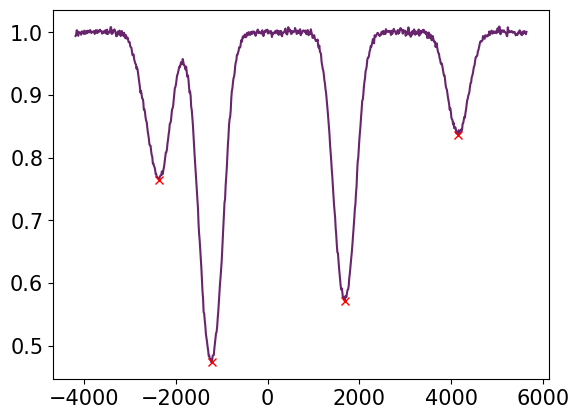

In [100]:

# Extract the dips in the spectrum
dips, _ = signal.find_peaks(-Vals_20, prominence=0.1)

# Plot dips
plt.plot(Time_20, Vals_20)
plt.plot(Time_20[dips], Vals_20[dips], "x", color='red')

print(Time_20[dips]*1e-3)

# For comparison: 
_Rb87F1 = 4.15; _Rb85F1 = 1.675; _Rb85F2 = -1.232; _Rb87F2 = -2.366
Rb_list = [_Rb87F2, _Rb85F2, _Rb85F1, _Rb87F1]

# Calculate the detunings
detunings = Time_20[dips]*1e-3 - Rb_list

print("Detuning in MHz: ", detunings*1e3)




## In the next three cells, we fit the three spectra using ElecSus. More details on the program can be found in the ElecSus documentation. 

Starting parameter dictionary:
 {'Elem': 'Rb', 'Dline': 'D2', 'T': 18, 'lcell': 0.075, 'Btheta': 0, 'Bfield': 0, 'shift': 0, 'Bphi': 0, 'GammaBuf': 0}

Perfoming Marquardt-Levenberg fitting routine.
ML Fit completed
[[Model]]
    Model(fit_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 800
    # variables        = 1
    chi-square         = 0.01268396
    reduced chi-square = 1.5875e-05
    Akaike info crit   = -8839.62316
    Bayesian info crit = -8834.93854
[[Variables]]
    E_x:       1 (fixed)
    E_y:       0 (fixed)
    E_phase:   0 (fixed)
    T:         19.6810296 +/- 0.01041611 (0.05%) (init = 18)
    lcell:     0.075 (fixed)
    Bfield:    0 (fixed)
    Btheta:    0 (fixed)
    Bphi:      0 (fixed)
    GammaBuf:  0 (fixed)
    shift:     0 (fixed)
    DoppTemp:  20 (fixed)
    rb85frac:  72.17 (fixed)
    K40frac:   0.01 (fixed)
    K41frac:   6.73 (fixed)
[[Model]]
    Model(fit_function)
[[Fit Statistics]]
 

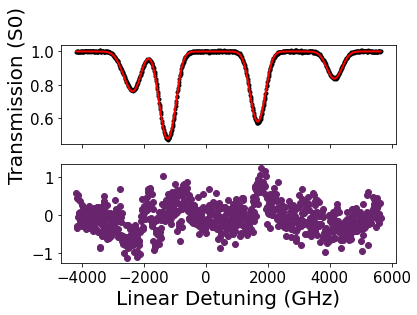

In [ ]:
#Fitting 20 degree spectrum
import elecsus.elecsus_methods as EM
import numpy as np
import matplotlib.pyplot as plt
#E_in defines the electric field polarisation in. Here we define linear horizontal light
E_in=np.array([1,0,0])
E_in_angle = [E_in[0].real,[abs(E_in[1]),np.angle(E_in[1])]]
E_in=E_in_angle
#The dictionary p_dict_1 defines various parameters including the element 'Elem' and Dline, temperature 'T' and length of vapour cell,
#'lcell'
p_dict_1 = {'Elem':'Rb','Dline':'D2','T':18,'lcell':75e-3,'Btheta':0,'Bfield':0,'shift':0,'Bphi':0,'GammaBuf':0}
p_dict_guess=p_dict_1
# 'p_dict_bools' defines which parameters are to be varied in the fit.
p_dict_bools={'T':True}
# 'p_dict_bounds' defines the lower and upper limits of the fit parameters
p_dict_bounds={}
p_dict_bounds['T'] = [0,25]
data=[Time_20,Vals_20]
# We are fitting a transmission/S0 spectrum 'S0' using the Marquardt-Levenburg fitting routine (ML)
best_params, RMS, result = EM.fit_data(data,p_dict_guess, p_dict_bools,E_in,p_dict_bounds, data_type='S0',fit_algorithm='ML')
report = result.fit_report()
elecsus_fit = result.best_fit
print(report)
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(Time_20,Vals_20,'k.',label='Data')
ax[0].plot(Time_20,elecsus_fit,'r-',lw=2,label='Fit')
ax[0].set_ylabel('Transmission (S0)')
ax[1].set_xlabel('Linear Detuning (GHz)')
#Residuals x100
ax[1].scatter(Time_20,100*(elecsus_fit-((Vals_20))))

Starting parameter dictionary:
 {'Elem': 'Rb', 'Dline': 'D2', 'T': 45, 'lcell': 0.075, 'Btheta': 0, 'Bfield': 0, 'shift': 0, 'Bphi': 0, 'GammaBuf': 0}

Perfoming Marquardt-Levenberg fitting routine.
ML Fit completed
[[Model]]
    Model(fit_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 800
    # variables        = 1
    chi-square         = 0.03699890
    reduced chi-square = 4.6307e-05
    Akaike info crit   = -7983.18305
    Bayesian info crit = -7978.49844
[[Variables]]
    E_x:       1 (fixed)
    E_y:       0 (fixed)
    E_phase:   0 (fixed)
    T:         40.1041876 +/- 0.01490653 (0.04%) (init = 45)
    lcell:     0.075 (fixed)
    Bfield:    0 (fixed)
    Btheta:    0 (fixed)
    Bphi:      0 (fixed)
    GammaBuf:  0 (fixed)
    shift:     0 (fixed)
    DoppTemp:  20 (fixed)
    rb85frac:  72.17 (fixed)
    K40frac:   0.01 (fixed)
    K41frac:   6.73 (fixed)
[[Model]]
    Model(fit_function)
[[Fit Statistics]]
 

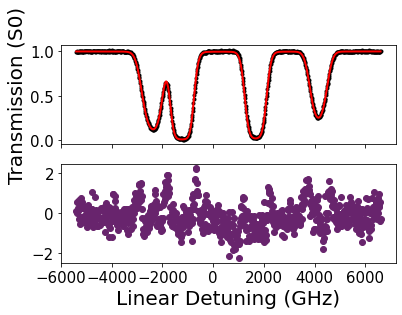

In [ ]:
#Fitting 45 degree spectrum
import elecsus.elecsus_methods as EM
import numpy as np
import matplotlib.pyplot as plt
E_in=np.array([1,0,0])
E_in_angle = [E_in[0].real,[abs(E_in[1]),np.angle(E_in[1])]]
E_in=E_in_angle
p_dict_1 = {'Elem':'Rb','Dline':'D2','T':45,'lcell':75e-3,'Btheta':0,'Bfield':0,'shift':0,'Bphi':0,'GammaBuf':0}
p_dict_guess=p_dict_1
p_dict_bools={'T':True}
p_dict_bounds={}
p_dict_bounds['T'] = [30,50]
data=[Time_40,Vals_40]
best_params, RMS, result = EM.fit_data(data,p_dict_guess, p_dict_bools,E_in,p_dict_bounds, data_type='S0',fit_algorithm='ML')
report = result.fit_report()
elecsus_fit2 = result.best_fit
print(report)
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(Time_40,Vals_40,'k.',label='Data')
ax[0].plot(Time_40,elecsus_fit2,'r-',lw=2,label='Fit')
ax[0].set_ylabel('Transmission (S0)')
ax[1].set_xlabel('Linear Detuning (GHz)')
ax[1].scatter(Time_40,100*(elecsus_fit2-Vals_40))

Starting parameter dictionary:
 {'Elem': 'Rb', 'Dline': 'D2', 'T': 75, 'lcell': 0.075, 'Btheta': 0, 'Bfield': 0, 'shift': 0, 'Bphi': 0, 'GammaBuf': 0}

Perfoming Marquardt-Levenberg fitting routine.
ML Fit completed
[[Model]]
    Model(fit_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 800
    # variables        = 1
    chi-square         = 0.03648015
    reduced chi-square = 4.5657e-05
    Akaike info crit   = -7994.47888
    Bayesian info crit = -7989.79426
[[Variables]]
    E_x:       1 (fixed)
    E_y:       0 (fixed)
    E_phase:   0 (fixed)
    T:         72.7655025 +/- 0.02364453 (0.03%) (init = 75)
    lcell:     0.075 (fixed)
    Bfield:    0 (fixed)
    Btheta:    0 (fixed)
    Bphi:      0 (fixed)
    GammaBuf:  0 (fixed)
    shift:     0 (fixed)
    DoppTemp:  20 (fixed)
    rb85frac:  72.17 (fixed)
    K40frac:   0.01 (fixed)
    K41frac:   6.73 (fixed)
[[Model]]
    Model(fit_function)
[[Fit Statistics]]
 

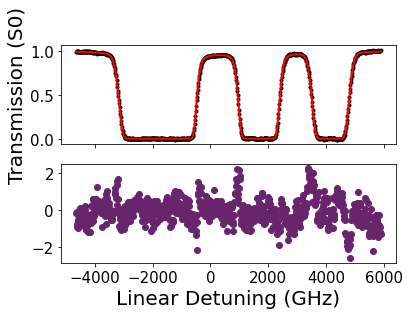

In [ ]:
#Fitting 73 degree spectrum
import elecsus.elecsus_methods as EM
import numpy as np
import matplotlib.pyplot as plt
E_in=np.array([1,0,0])
E_in_angle = [E_in[0].real,[abs(E_in[1]),np.angle(E_in[1])]]
E_in=E_in_angle
p_dict_1 = {'Elem':'Rb','Dline':'D2','T':75,'lcell':75e-3,'Btheta':0,'Bfield':0,'shift':0,'Bphi':0,'GammaBuf':0}
p_dict_guess=p_dict_1
p_dict_bools={'T':True}
p_dict_bounds={}
p_dict_bounds['T'] = [60,85]
data=[Time_73,Vals_73]
best_params, RMS, result = EM.fit_data(data,p_dict_guess, p_dict_bools,E_in,p_dict_bounds, data_type='S0',fit_algorithm='ML')
report = result.fit_report()
elecsus_fit3 = result.best_fit
print(report)
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(Time_73,Vals_73,'k.',label='Data')
ax[0].plot(Time_73,elecsus_fit3,'r-',lw=2,label='Fit')
ax[0].set_ylabel('Transmission (S0)')
ax[1].set_xlabel('Linear Detuning (GHz)')
ax[1].scatter(Time_73,100*(elecsus_fit3-Vals_73))

## Display Theory on Experiment with Fit Residuals

Text(0, 0.5, 'Normalised Transmission')

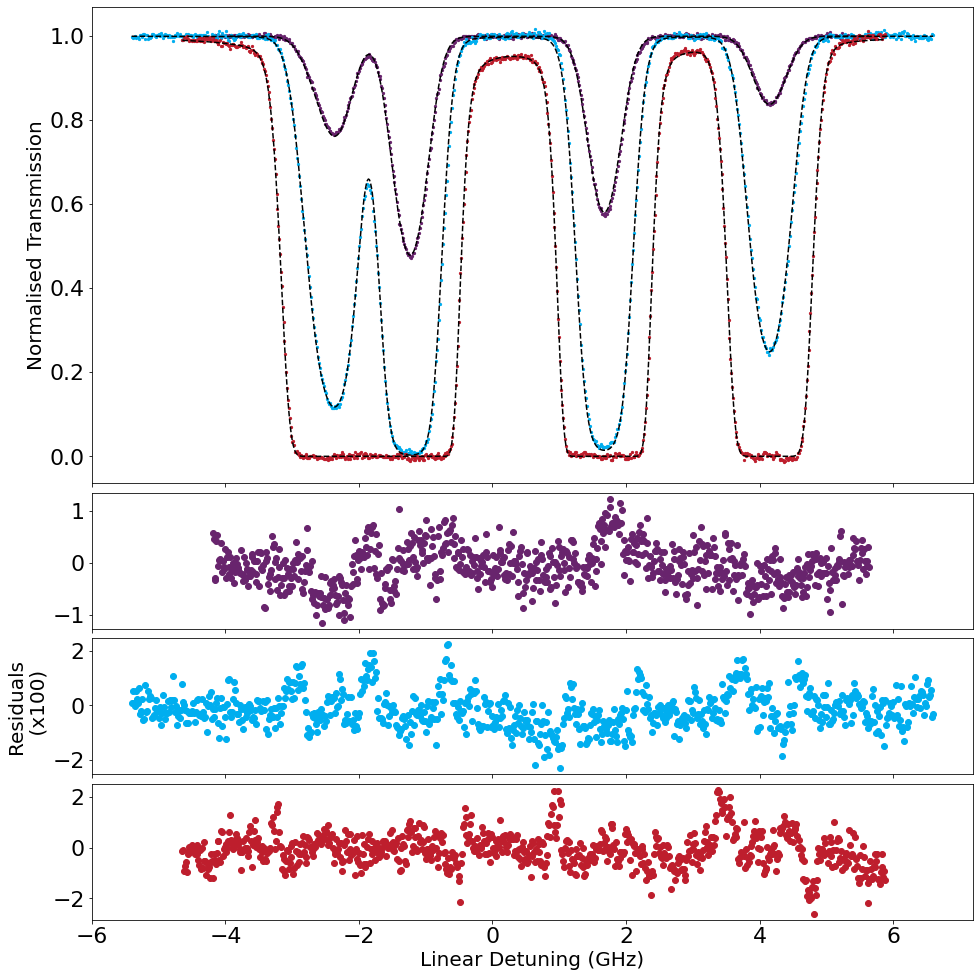

In [ ]:
#Figure 13 from Paper
from matplotlib.gridspec import GridSpec
%matplotlib inline
fig=plt.figure(figsize=(9*1.5,9*1.6),constrained_layout=True)
gs = GridSpec(14,2, figure=fig)
ax3 = fig.add_subplot(gs[1:8, :2])
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = fig.add_subplot(gs[8:10,:2],sharex=ax3,)
ax5 = fig.add_subplot(gs[10:12,:2],sharex=ax3)
ax6 = fig.add_subplot(gs[12:14,:2],sharex=ax3)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
ax3.scatter(Time_20/1e3,Vals_20,s=5,color='#68246D')
ax3.scatter(Time_40/1e3,Vals_40,s=5,color='#00AEEF')
ax3.scatter(Time_73/1e3,Vals_73,s=5,color='#BE1E2D',)
ax3.plot(Time_20[20:]/1e3,elecsus_fit[20:],'black',linestyle='dashed',zorder=2)
ax3.plot(Time_40/1e3,elecsus_fit2,'black',linestyle='dashed',zorder=2)
ax3.plot(Time_73/1e3,elecsus_fit3,'black',linestyle='dashed',zorder=2)
ax4.scatter(Time_20/1e3,100*(elecsus_fit-Vals_20))
ax5.scatter(Time_40/1e3,100*(elecsus_fit2-Vals_40),color='#00AEEF')
ax6.scatter(Time_73/1e3,100*(elecsus_fit3-Vals_73),color='#BE1E2D')
ax1.tick_params(axis='both', which='major', labelsize=22)
ax2.tick_params(axis='both', which='major', labelsize=22)
ax5.set_yticks([-2,0,2])
ax3.tick_params(axis='both', which='major', labelsize=22)
ax4.tick_params(axis='both', which='major', labelsize=22)
ax5.tick_params(axis='both', which='major', labelsize=22)
ax6.tick_params(axis='both', which='major', labelsize=22)
ax1.set_ylabel('Photodiode\n Output (V)')
ax1.set_xlabel('Linear Detuning (GHz)')
ax2.set_xlabel('Linear Detuning (GHz)')
ax6.set_xlabel('Linear Detuning (GHz)')
ax5.set_ylabel('Residuals\n (x100)')
ax3.set_ylabel('Normalised Transmission')

## Appendix: Normalising and Deriving a Zero from a Hot Spectrum (Following 'Zero-ing' Discussion in Section 3.2)

## Choose Zero Points on Hot Spectrum

In [ ]:
'''
#Step 1: Find the Zero Line
%matplotlib
plt.plot(Hot_Spectrum_Frequencies,Hot_Spectrum_Voltages)


#Collect mouse input
x_zeros = plt.ginput(6) 

plt.show(block=False)
plt.close()
'''

'\n#Step 1: Find the Zero Line\n%matplotlib\nplt.plot(Hot_Spectrum_Frequencies,Hot_Spectrum_Voltages)\n\n\n#Collect mouse input\nx_zeros = plt.ginput(6) \n\nplt.show(block=False)\nplt.close()\n'

## Zero Points from Paper

In [ ]:
x_zeros=[(1.7400576705241937, 0.05543383919665015),
 (3.9135362992741944, 0.053847781771920115),
 (5.806566072701615, 0.053847781771920115),
 (6.8270882962365596, 0.051733038538946736),
 (8.416298476397852, 0.051204352730703395),
 (9.17195233657258, 0.05067566692246005)]

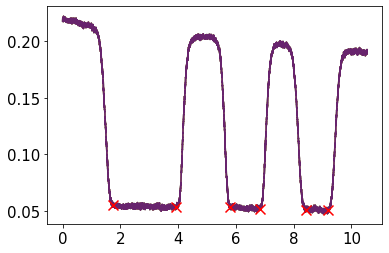

In [ ]:
%matplotlib inline
for i in x_zeros:
    plt.scatter(i[0],i[1],s=100,marker='x',zorder=2,color='red')
    plt.plot(Hot_Spectrum_Frequencies,Hot_Spectrum_Voltages,zorder=1)

## Zero Regions Defined

Text(0, 0.5, 'Signal (V)')

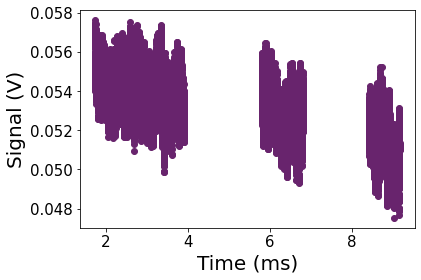

In [ ]:
a = np.argmin(np.abs(Hot_Spectrum_Frequencies- x_zeros[0][0]))
b = np.argmin(np.abs(Hot_Spectrum_Frequencies- x_zeros[1][0]))
c = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_zeros[2][0]))
d = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_zeros[3][0]))
e = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_zeros[4][0]))
f = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_zeros[5][0]))

offResX = np.append(Hot_Spectrum_Frequencies[a:b], Hot_Spectrum_Frequencies[c:d]) 
offResX = np.append(offResX,Hot_Spectrum_Frequencies[e:f])

offResTrace = np.append(Hot_Spectrum_Voltages[a:b], Hot_Spectrum_Voltages[c:d])
offResTrace = np.append(offResTrace,Hot_Spectrum_Voltages[e:f])

plt.plot(offResX,offResTrace,'o')
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')


Text(0, 0.5, 'Signal (V)')

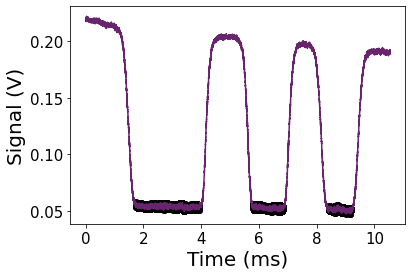

In [ ]:
plt.plot(offResX,offResTrace,'ok')
plt.plot(Hot_Spectrum_Frequencies,Hot_Spectrum_Voltages)
plt.xlabel('Time (ms)')
plt.ylabel('Signal (V)')

## Fit Zeros. Change polynomial order as needed.

In [ ]:
params1=[1.0,1.0]

coeffs, matcov = curve_fit(poly1,offResX,offResTrace, params1)

A, B = coeffs[0], coeffs[1]
print(A,B)

-0.0004582902395435899 0.055466977512227796


In [ ]:
'''params2=[1.0,1.0,1.0]

coeffs, matcov = curve_fit(poly2,offResX,offResTrace, params2)

A, B,C = coeffs[0], coeffs[1],coeffs[2]
print(A,B,C)'''

'params2=[1.0,1.0,1.0]\n\ncoeffs, matcov = curve_fit(poly2,offResX,offResTrace, params2)\n\nA, B,C = coeffs[0], coeffs[1],coeffs[2]\nprint(A,B,C)'

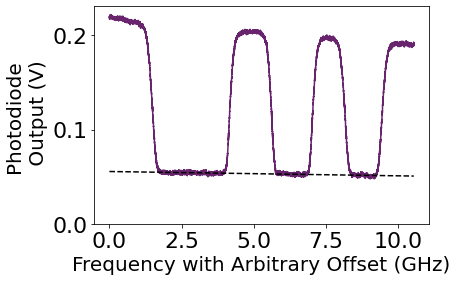

In [ ]:
#a) from Figure 9
plt.plot(Hot_Spectrum_Frequencies,Hot_Spectrum_Voltages)
plt.plot(Hot_Spectrum_Frequencies,poly1(Hot_Spectrum_Frequencies,*coeffs),linestyle='dashed',color='black',zorder=2)
plt.xlabel('Frequency with Arbitrary Offset (GHz)')
plt.ylabel('Photodiode \n Output (V)')
plt.ylim(0,)
plt.tick_params(axis='both', which='major', labelsize=22)

## Hot Spectrum Zeroed

Text(0, 0.5, 'Photodiode \n Output (V)')

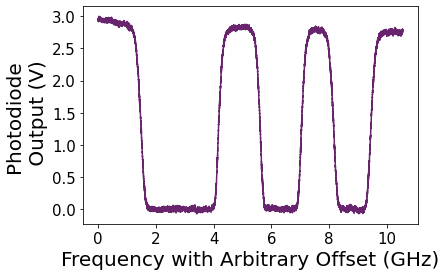

In [ ]:
Zeroed_Spec = Hot_Spectrum_Voltages/poly1(Hot_Spectrum_Frequencies,*coeffs)-1
plt.plot(Hot_Spectrum_Frequencies,Zeroed_Spec)
plt.xlabel('Frequency with Arbitrary Offset (GHz)')
plt.ylabel('Photodiode \n Output (V)')

## The Zero_poly can now be used as reference of zero for other spectra

In [ ]:
Zero_poly=poly1(Hot_Spectrum_Frequencies,*coeffs)

## For example:

Text(0, 0.5, 'Photodiode \n Output (V)')

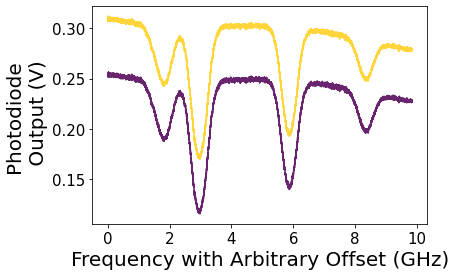

In [ ]:
plt.plot(Linearised_Time*Freq_per_time/1e3,Dopp_Broad_Spec-(A*Linearised_Time*Freq_per_time/1e3+B))
plt.plot(Linearised_Time*Freq_per_time/1e3,Dopp_Broad_Spec)
plt.xlabel('Frequency with Arbitrary Offset (GHz)')
plt.ylabel('Photodiode \n Output (V)')

## We now continue linearisation of hot spectrum

## Choose points where spectrum is 1 or near 1

In [ ]:
'''
%matplotlib
plt.plot(Hot_Spectrum_Frequencies,Zeroed_Spec)


#Collect mouse input
x_ones = plt.ginput(8) 

plt.show(block=False)
plt.close()'''

'\n%matplotlib\nplt.plot(Hot_Spectrum_Frequencies,Zeroed_Spec)\n\n\n#Collect mouse input\nx_ones = plt.ginput(8) \n\nplt.show(block=False)\nplt.close()'

## One Points Used in Paper

In [ ]:
x_ones=[(0.5637305273655917, 2.921890603386382),
 (4.747092619260753, 2.837981256157135),
 (4.980799998696238, 2.847304516960385),
 (7.489259204637098, 2.791364952140887),
 (7.691805600147851, 2.8100114737473865),
 (10.208055052069895, 2.7773800609360126)]

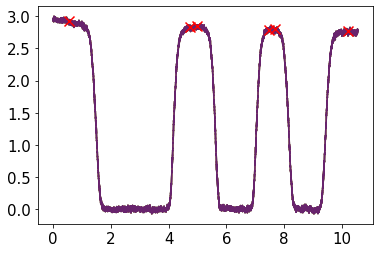

In [ ]:
%matplotlib inline
for i in x_ones:
    plt.scatter(i[0],i[1],s=100,marker='x',zorder=2,color='red')
    plt.plot(Hot_Spectrum_Frequencies,Zeroed_Spec,zorder=1)

## One regions defined. Note that three regions are not exactly one. The choice of offsets from one (0.02, 0.13 and 0.09 in this case) are found through trial and error. 

In [ ]:
a = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_ones[0][0]))
b = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_ones[1][0]))
c = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_ones[2][0]))
d = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_ones[3][0]))
e = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_ones[4][0]))
f = np.argmin(np.abs(Hot_Spectrum_Frequencies - x_ones[5][0]))

offResX = np.append(Hot_Spectrum_Frequencies[:a], Hot_Spectrum_Frequencies[b:c])
offResX = np.append(offResX,Hot_Spectrum_Frequencies[d:e])
offResX = np.append(offResX,Hot_Spectrum_Frequencies[f:])

offResTrace = np.append((Zeroed_Spec[:a])+0.02, (Zeroed_Spec[b:c])+0.13)
offResTrace = np.append(offResTrace,(Zeroed_Spec[d:e])+0.09)
offResTrace = np.append(offResTrace,(Zeroed_Spec[f:]))


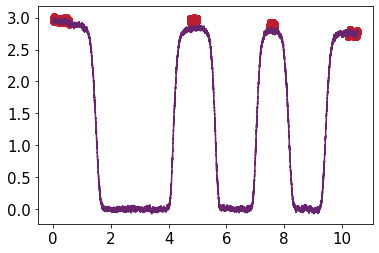

In [ ]:
plt.scatter(offResX,offResTrace,color='#BE1E2D')
plt.plot(Hot_Spectrum_Frequencies,Zeroed_Spec)

## Fitting the ones with a polynomial

In [ ]:
params5 = [1.0,1.0,1.0,1.0,1.0,1.0]

coeffs, matcov = curve_fit(poly5,offResX,offResTrace, params5)

A, B, C, D, E, F = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5]

## Normalised Hot Spectrum

Text(0, 0.5, 'Transmission')

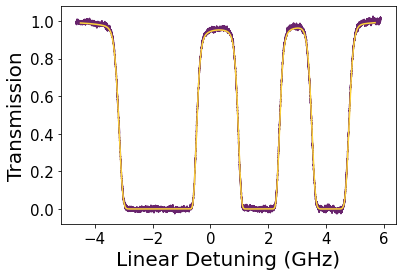

In [84]:
Norm_Hot_Spec = Zeroed_Spec/poly5(Hot_Spectrum_Frequencies,*coeffs)
plt.plot(Hot_Spectrum_Frequencies-4.6502350438882285,Norm_Hot_Spec) #-4.6502350438882285 from absolute frequency calibration
from elecsus.libs import spectra as sp
detuning=np.linspace(-4.5,5.7,1000)*1e3
E_in=np.array([1,0,0])
p_dict= {'Elem':'Rb','Dline':'D2','T':72.7,'lcell':75e-3}
[fit]=sp.get_spectra(detuning,E_in,p_dict,outputs=['S0'])
plt.plot(detuning/1e3,fit)
plt.xlabel('Linear Detuning (GHz)')
plt.ylabel('Transmission')

## Troubleshooting Tips:

## 1) The commented sections are points in the code where the user needs to input points. After getting a feel for the code, uncomment these sections and comment out any 'points from the paper'.

## 2) Due to certain elements being redefined in the code, rerunning certain cells may lead to errors or strange results. If this is the case, restart the kernel and run from the beginning.

## 3) The linearisation and normalisation process make frequent use of polynomials. What order polynomial to choose requires some trial and error. Do also note that odd and even ordered polynomials have different symmetries.

## 4) During normalisation, choosing appropriate points to be normalised to one can be tricky, (see Notebook Appendix). This too is a process that requires trial and error and creative solutions are often needed. For instance, in the case of the Hot Spectrum, zeroing first and selecting points near but not quite equal to one.

## 5) For more information about Step 5, refer to the ElecSus documentation and 'fitting_tests' in the 'tests' folder of ElecSus

In [ ]:
#Version 29 07 2022